# Разработка модели машинного обучения для прогноза оттока клиентов

**Описание проекта:**
Оператор связи «ТелеДом» хочет снизить отток клиентов. Для этого планируется заранее выявлять абонентов с высоким риском расторжения договора и адресно предлагать им промокоды и спецусловия. У нас есть персональные данные клиентов, информация о договорах, типах подключений и дополнительных услугах. Необходимо построить модель, которая предсказывает факт расторжения договора (отток) по совокупности этих признаков.

**Цель проекта:**
Разработать и подобрать лучшую модель для прогноза оттока клиентов, определить ключевые факторы, влияющие на уход, и оценить потенциал внедрения системы проактивного удержания. Основная метрика: **ROC-AUC** (целевое значение на тестовой выборке ≥ **0.85**). Дополнительно: **accuracy**, **precision/recall**, матрица ошибок, PR-кривая.

**Ход исследования:**

- **Подготовка данных:** подключение к базе **SQLite**, проверка наличия и наполненности таблиц, соответствия их количеству и структуре условию.
- **Исследовательский анализ:** проверка типов, пропусков, аномалий, изучение распределений и долей категорий, поиск противоречий с бизнес-логикой телеком-услуг.
- **Объединение данных:** джойн таблиц по `customerID` так, чтобы на абонента приходилась **ровно одна строка**. Учет особенностей: множественные телефонные линии, тип интернет-подключения и набор допуслуг.
- **Формирование признаков:** инженерия доп.фичей при необходимости и их отбор.
- **Моделирование и подбор гиперпараметров:** предобработка отоборанных признаков. Обучение нескольких моделей для поиска лучшей: логистическая регрессия (вкачестве базовой), **дерево/случайный лес**, **градиентные бустинги**, **нейронная сеть**.
- **Оценка и интерпретация:** Тестирование лучшей модели на отложенной выборке; отчёты: ROC-AUC, accuracy, матрица ошибок, precision/recall. Анализ важности признаков (Permutation Importance / SHAP). 
- **Выводы и рекомендации:** итоговые выводы о достижении метрик, список ключевых драйверов оттока, гипотезы действий для удержания (какие сегменты кому и что предлагать), идеи по улучшению данных и модели.

**Данные:**

* **contract** — договор: `customerID`, `BeginDate`, `EndDate` (таргет), `Type` (периодичность оплаты), `PaperlessBilling`, `PaymentMethod`, `MonthlyCharges`, `TotalCharges`. 
* **personal** — персональные: `customerID`, `gender`, `SeniorCitizen`, `Partner`, `Dependents`.
* **internet** — интернет-услуги: `customerID`, `InternetService` (DSL/Fiber/None), `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`.
* **phone** — телефония: `customerID`, `MultipleLines`.

In [1]:
import os
import pandas as pd
import numpy as np
import math
import phik
import seaborn as sns
import shap
from textwrap import fill
import matplotlib.pyplot as plt

from sqlalchemy import create_engine, text, inspect

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import (OneHotEncoder,
                                   StandardScaler,
                                   MinMaxScaler)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import (roc_auc_score,
                             accuracy_score,
                             confusion_matrix,
                             precision_score,
                             recall_score)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import torch
import torch.nn as nn
from math import ceil

import optuna
from optuna.samplers import TPESampler

from src.vizualization import (category_graph,
                               numeric_graph,
                               category_graph_compare,
                               numeric_graph_compare)
from src.data_prepare import snake_columns_rename, data_info

RANDOM_STATE = 51125
TEST_SIZE = 0.25
CONTROL_DATE = pd.Timestamp('2020-02-01')

## Загрузка данных

Выполним подключение к базе данных. Необходимый файл с расширением db мы загрузили ранее с помощью команды wget, согласно инструкции в ТЗ.

In [8]:
path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False) 

Выведем список существующих таблиц и удостоверимся, что у нас есть все необходимые таблицы и они не пустые.

In [9]:
insp = inspect(engine)
tables = insp.get_table_names()
print('Найдены таблицы:', tables)

expected_tables = {'contract', 'personal', 'internet', 'phone'}
missing = expected_tables - set(tables)

print('Отсутствуют из необходимых:', missing if missing else '—')

row_counts = {}
with engine.connect() as conn:
    for table in expected_tables:
        cnt = conn.execute(text(f'SELECT COUNT(*) FROM {table}')).scalar()
        row_counts[table] = cnt
        
print('__' * 20)
print('Кол-во строк в таблицах:')
for table, cnt in row_counts.items():
    print(f'{table} : {cnt} строк')

Найдены таблицы: ['contract', 'data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire_time', 'internet', 'personal', 'phone']
Отсутствуют из необходимых: —
________________________________________
Кол-во строк в таблицах:
contract : 7043 строк
internet : 5517 строк
personal : 7043 строк
phone : 6361 строк


В базе больше таблиц, чем нам требуется. Однако, все необходимые на месте и они не пустые. Сосредоточимся на них.

In [11]:
dfs = {}
for table in expected_tables:
    dfs[table] = pd.read_sql_query(f'SELECT * FROM {table}', con=engine)

df_contract = dfs['contract']
print(f'== df_contract ==')
display(df_contract.info())
display(df_contract.head(2))

df_personal = dfs['personal']
print(f'== df_personal ==')
display(df_personal.info())
display(df_personal.head(2))

df_internet = dfs['internet']
print(f'== df_internet ==')
display(df_internet.info())
display(df_internet.head(2))

df_phone = dfs['phone']
print(f'== df_phone ==')
display(df_phone.info())
display(df_phone.head(2))

== df_contract ==
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           7043 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7043 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84


== df_personal ==
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No


== df_internet ==
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No


== df_phone ==
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerId     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,CustomerId,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No


Названия столбцов приведем к общепринятому формату 'snake_case'.

In [4]:
df_contract = snake_columns_rename(df_contract)
df_personal = snake_columns_rename(df_personal)
df_internet = snake_columns_rename(df_internet)
df_phone = snake_columns_rename(df_phone)

В таблицах `personal`, `internet`, `phone` - основные данные - бинарные признаки (категориальные). Их можно оставить в строковом формате. Необходимо привести к корректным типам данные в таблице `df_contract`. Причём end_date='no' трактуем как активный договор (NaT). Выделим колонки, которые необходимо преобразовать. 

In [5]:
DATE_COLUMNS = ['begin_date', 'end_date'] 
FLOAT_COLUMNS = ['monthly_charges', 'total_charges']

Перед изменением поля `end_date` сформируем целевую переменную: у абонентов со значением 'No' в этой колонке целевая переменная = 0 (клиент не ушел/не закрыл договор), там где есть дата окончания договора = 1.

In [6]:
df_contract['target'] = 0
df_contract.loc[df_contract['end_date'] != 'No', 'target'] = 1

In [7]:
df_contract['target'].value_counts()

target
0    5942
1    1101
Name: count, dtype: int64

In [8]:
df_contract.loc[df_contract['end_date'] != 'No', 'end_date'].count()

np.int64(1101)

In [8]:
for column in DATE_COLUMNS:
    df_contract[column] = pd.to_datetime(df_contract[column], 
                                       format='%Y-%m-%d',  
                                       errors='coerce')

In [11]:
df_contract['end_date'].isna().sum()

np.int64(5942)

Целевая переменная сформирована коректно. Столбцы с датами приведены к корректному типу datetime.
Изменим тип данных для соответствующих колонок на числовой и посмотрим на общую информацию по каждой таблице. 

In [9]:
for column in FLOAT_COLUMNS:
    df_contract[column] = pd.to_numeric(df_contract[column], errors='coerce')

In [12]:
data_info(df_contract)

Размер таблицы (7043, 9)


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   target             7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


,count,mean,min,25%,50%,75%,max,std
begin_date,7043,2017-04-30 13:01:50.918642688,2013-10-01 00:00:00,2015-06-01 00:00:00,2017-09-01 00:00:00,2019-04-01 00:00:00,2020-02-01 00:00:00,NaN
end_date,1101,2018-03-12 18:21:15.204359680,2014-06-01 00:00:00,2017-05-01 00:00:00,2018-06-01 00:00:00,2019-04-01 00:00:00,2020-01-01 00:00:00,NaN
monthly_charges,7043.0,64.761692,18.25,35.5,70.35,89.85,118.75,30.090047
total_charges,7032.0,2118.621822,19.05,439.745,1345.275,3239.3175,9221.38,2112.736199
target,7043.0,0.156325,0.0,0.0,0.0,0.0,1.0,0.363189


customer_id             0
begin_date              0
end_date             5942
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
target                  0
dtype: int64

Количество уникальных ID: 7043
Количество явных дубликатов: 0


In [17]:
print(df_contract['begin_date'].max())
print(df_contract['begin_date'].min())

2020-02-01 00:00:00
2013-10-01 00:00:00


1. Количество пропусков в поле `end_date` соответствует таргету и обозначает пользователей контракт которых является действующим. Дата окончания договора не будет использоваться в датасете, т.к. эта информация недоступна на момент прогнозирования оттока и будет являться утечкой данных. Пропуски можно заполнить максимальной датой в датасете (= текущая дата).
2. Есть небольшое количество пропусков в поле `total_charges`, которые будут обработаны на следующем этапе. Возможно, пропуски имеют место для совсем новых клиентов где информация о 
3. Есть дисбаланс в целевой переменной (ушедших пользователей ~ 15,6%). В дальнейшем необходимо использовать стратификацию при делении выборок на обучающую и тестовую и использовать при обучении параметр модели `class_weight='balanced'` там где это возможно.
4. Данные представлены во временном диапазоне с октября 2013 по февраль 2020.
5. Все ID представленные в выборке уникальны.
6. В поле `monthly_charges` среднее достаточно близко к медиане. Можно сделать вывод, что данные умеренно "скошены" влево и не имеют значенительных выбросов. Поле `total_charges` имеет более значительный разброс между средним и медианой, что логично с учетом накопительной природы этих данных. Среднее сильно выше медианы - значит у большинства клиентов суммы **низкие–средние**, а «очень большие» суммы встречаются редко. Следовательно, **бóльшая доля базы — относительно новые/не «очень старые» клиенты**. 
7. В данных нет явных дубликатов.

In [18]:
data_info(df_personal)

Размер таблицы (7043, 5)


,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   object
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


,count,unique,top,freq
customer_id,7043,7043,7590-VHVEG,1
gender,7043,2,Male,3555
senior_citizen,7043,2,0,5901
partner,7043,2,No,3641
dependents,7043,2,No,4933


customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

Количество уникальных ID: 7043
Количество явных дубликатов: 0


1. Количество уникальных ID совпадает с размером датасета и предыдущей таблицей. 
2. Пропусков и явных дубликатов нет.
3. Распределение клиентов по полям `gender` и `partner` практически 50/50. Мужчин чуть больше, чем женщин (50,48%), холостых - 51,7%.
4. Доля пенсионеров - 16,21%. Дети есть у ~ 30% абонентов. 
5. Количество уникальных значений в бинарных признаках - 2. То есть в данных нет неявных дубликатов и ошибок.

In [19]:
data_info(df_internet)

Размер таблицы (5517, 8)


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,count,unique,top,freq
customer_id,5517,5517,7590-VHVEG,1
internet_service,5517,2,Fiber optic,3096
online_security,5517,2,No,3498
online_backup,5517,2,No,3088
device_protection,5517,2,No,3095
tech_support,5517,2,No,3473
streaming_tv,5517,2,No,2810
streaming_movies,5517,2,No,2785


customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64

Количество уникальных ID: 5517
Количество явных дубликатов: 0


1. Уникальных `customer_id` = 5517, что совпадает с размером таблицы, **но меньше**, чем в `contract/personal` (7043). Значит, 1526 клиентов не используют интернет-услуги и отсутствуют здесь. При объединении таблиц такие клиенты дадут пропуски - их можно заполнить значением "NO INTERNET SERVICE".
2. Пропусков и явных дубликатов нет.
3. По типу интернет подключения преобладает `Fiber optic` (≈ 56.1%).
4. Среди подписок на допуслуги преобладает с небольшим перевесом значение **No**.
5. Во всех бинарных полях ровно 2 уникальных значения (Yes/No) — неявных дубликатов/опечаток на данном этапе не обнаружено.

In [20]:
data_info(df_phone)

Размер таблицы (6361, 2)


,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,count,unique,top,freq
customer_id,6361,6361,5575-GNVDE,1
multiple_lines,6361,2,No,3390


customer_id       0
multiple_lines    0
dtype: int64

Количество уникальных ID: 6361
Количество явных дубликатов: 0


1. Уникальных `customer_id` = 6361, что совпадает с размером таблицы, но меньше, чем в `contract`/`personal` (7043). Значит, 682 клиента не используют услуги телефонии. При объединении можно заполнить возникшие пропуски значением "NO PHONE SERVICE". 
2. Пропусков и явных дубликатов нет.
3. Несколько телефонных линий используют ≈ 46.7%. Значит, большинство телефонных абонентов имеют одну линию.
4. В бинарном признаке ровно 2 уникальных значения — неявных дубликатов/опечаток не обнаружено.

<b>Вывод по разделу "Загрузка данных"</b>

В ходе первичной загрузки и подготовки данных:
- Все колонки приведены к `snake_case`. 
- Типы данных в полях `begin_date/end_date`  приведены к datetime`, `monthly_charges/total_charges' к типу float. Остальные таблицы (бинарные поля) оставляем строковыми/категориальными до этапа кодирования.
- Целевая переменная сформирована из поля `end_date` по правилу: 'no' = 0, дата = 1. Обнаружен дисбаланс классов в целевой переменной. В дальнейшем используем стратифицированный сплит и, где возможно, параметр `class_weight='balanced'` при обучении моделей.
- В `total_charges` есть 11 пропусков (вероятно, очень «новые» клиенты) — обработаем их при подготовке признаков.
— В таблицах `internet` и `phone` меньше строк, чем в `contract`: часть клиентов **без интернета/телефонии**. При объединении интерпретируем пропуски как отсутствующую услугу `no internet/phone service`.
- Данные покрывают период окт. 2013 — фев. 2020. При вычислении доп.признаков (при необходимости) будем считать их относительно 2020-02-01.
- Поле `end_date` исключим из данных перед обучением, т.к. информация в этом поле будет недоступна на момент прогнозирования оттока и будет являться "утечкой данных".

## Исследовательский анализ данных

При первичном анализе данных в таблицах, мы обнаружили, что явных и неявных дубликатов в данных нет. 

Для наглядности визуализируем распределение признаков и начнем с категориальных признаков. Для бинарных признаков используем круговую диаграмму, для остальных - столбчатую. В с вязи с большим количеством анализируемых переменных настроим компактный вывод графиков с помощью сетки `subplots`.

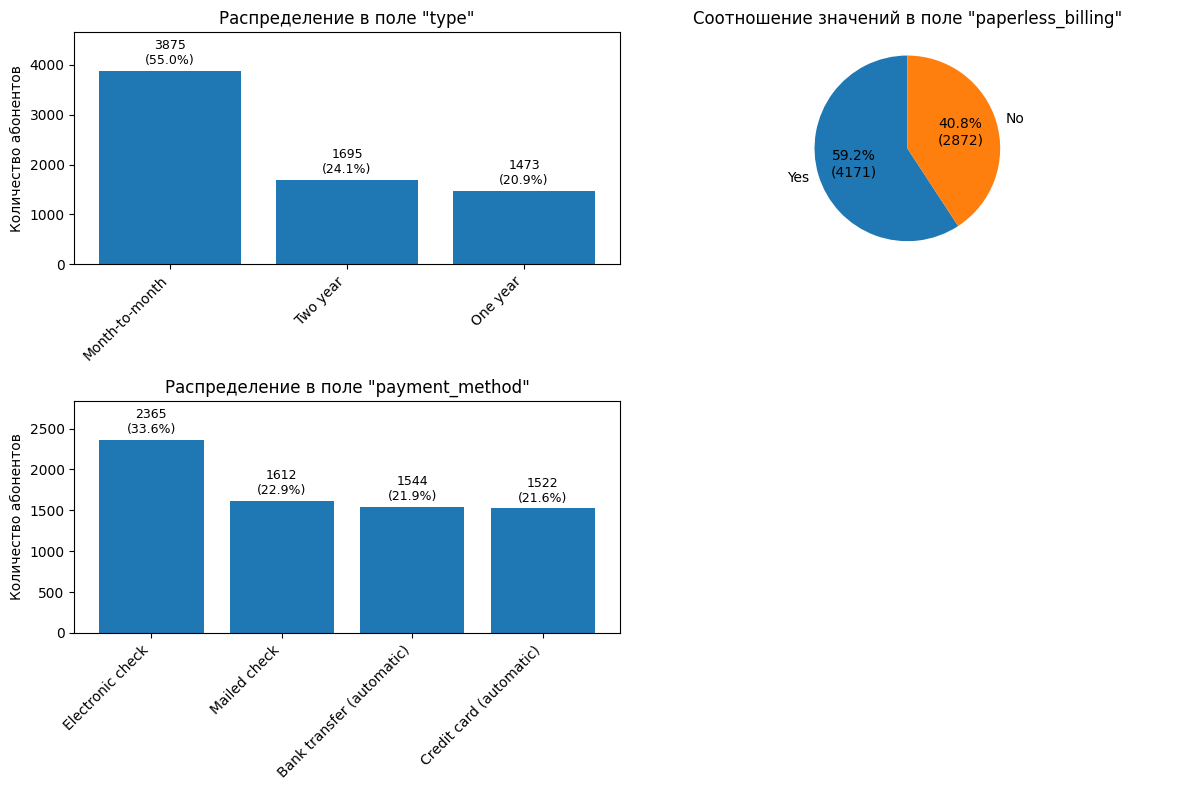

In [13]:
category_graph(df_contract, ['type', 'paperless_billing', 'payment_method'])

Из графиков мы видим, что большинство клиентов (55%) используют помесячную оплату с неавтоматизированными платежами (56,5%). Большая часть клиентов перешла на выставление электронных счетов (59,2%). 

С точки зрения бизнеса эти данные говорят нам о:
1. Высокой мобильности клиентов - преобладание помесячных договоров показывает, что клиенты не привязаны надолго
2. Современности клиентов - большинство готово к digital-взаимодействию (переходу на электронные платежки).
3. Наличии потенциала для роста лояльности - низкая доля автоплатежей (43%) означает, что клиенты каждый месяц принимают решение об оплате. Такие клиенты требуют дополнительной мотивации для долгосрочного сотрудничества.

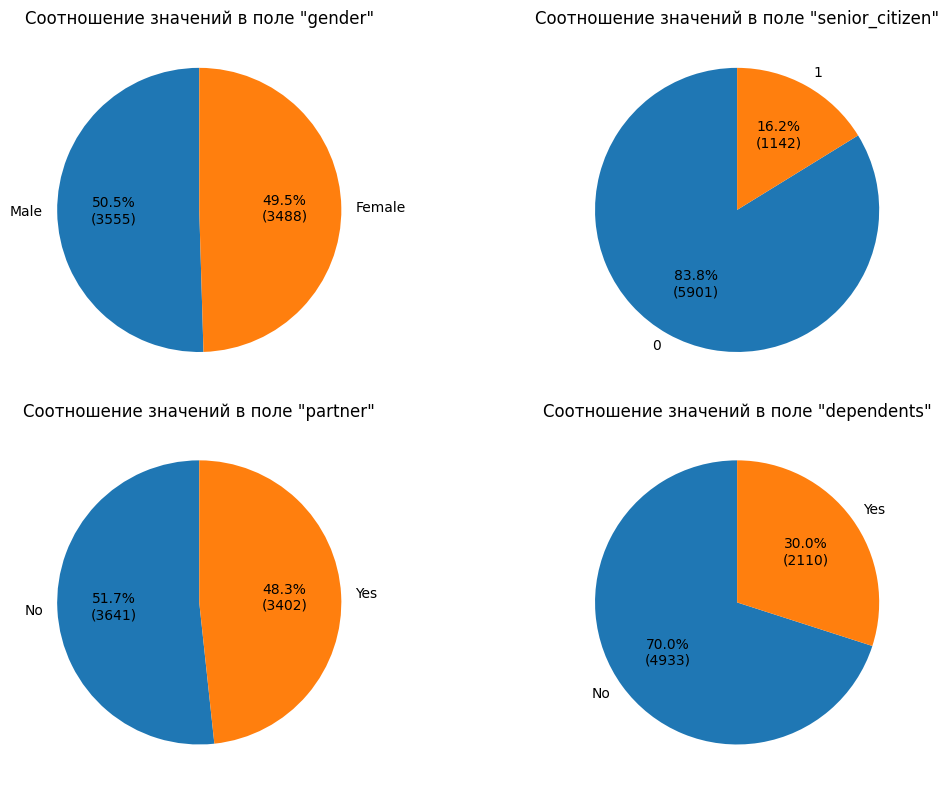

In [10]:
category_graph(df_personal, df_personal.columns.drop('customer_id').tolist())

Согласно персональным данным среди клиентов преобладают абоненты не пенсионного возраста (83,8%), преимущественно в малых "домохозяйствах" (без детей - 70% и нередко холостые - 51,7%). 

Для бизнеса это может означать, что наши клиенты склонны к персонализированным предложениям и простым тарифам без семейных опций. 

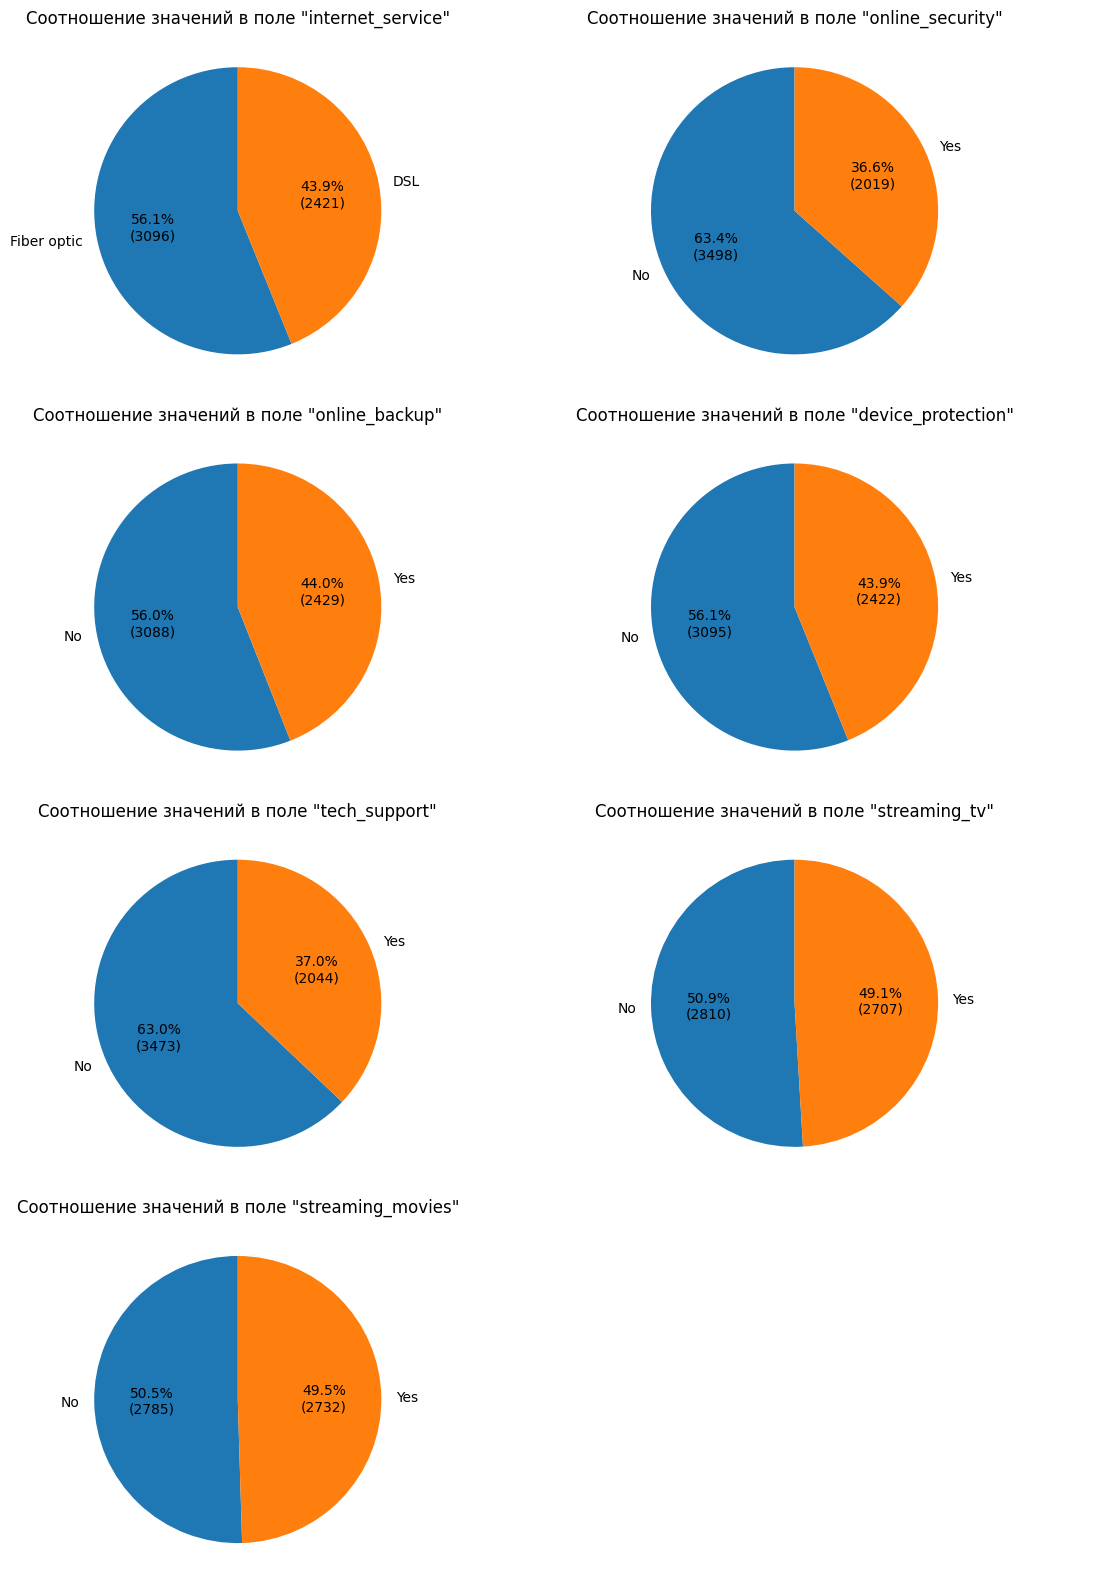

In [11]:
category_graph(df_internet, df_internet.columns.drop('customer_id').tolist())

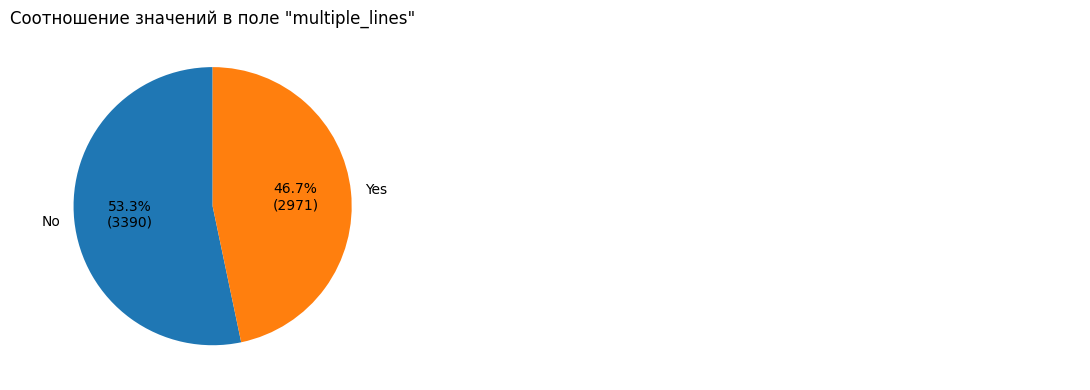

In [12]:
category_graph(df_phone, df_phone.columns.drop('customer_id').tolist())

Интернет подключен у большинства клиентов (чаще оптоволокно). При этом такие допуслуги как безопасность, бэкап и техподдержка подключены меньше,чем у половины. Возможно, клиенты не видят в них ценности или просто не знают о них. В таком случае тут есть потенциал для допродаж и выгодных пакетов. Половина пользователей использует стриминговые сервисы и несколько телефонных линий (47%).

Посмотрим на количественные признаки `monthly_charges` и `total_charges`.

Перед формированием графиков заполним пропуски в поле `total_charges`. Предполагаем, что клиенты у которых не заполнено это поле - это новые клиенты, которые просто не успели накопить сумму. Проверим, что минимальная дата начала договора у таких клиентов = макисмальной в нашем датасете (февраль 2020). В этом случае логично будет заполнить пропуски нулями - сумма еще не накоплена.

In [10]:
df_contract.loc[df_contract['total_charges'].isna(), 'begin_date'].min()

Timestamp('2020-02-01 00:00:00')

In [11]:
df_contract['total_charges'] = df_contract['total_charges'].fillna(0)

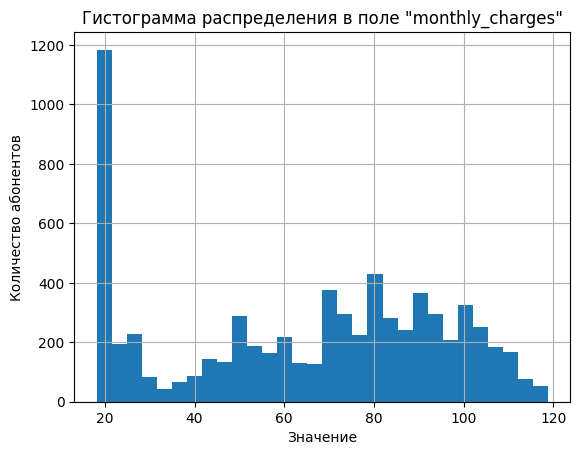

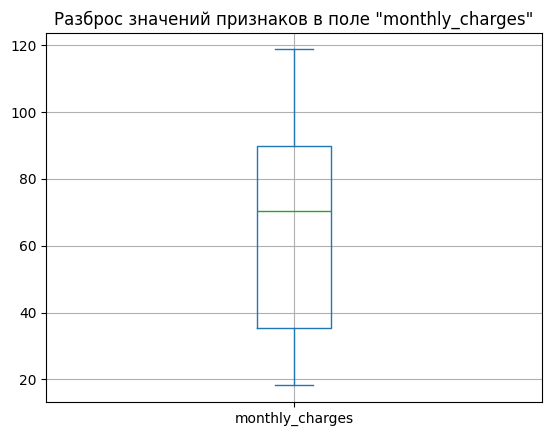

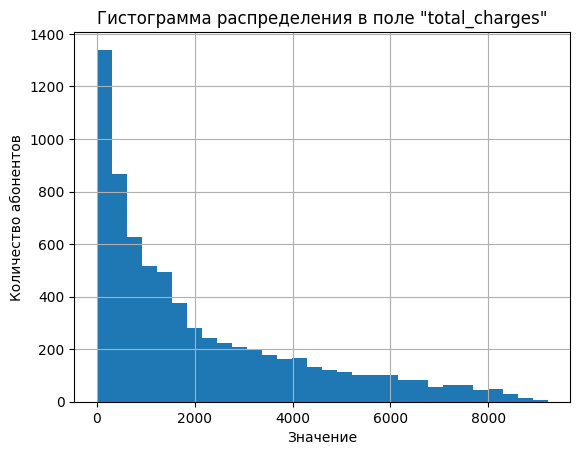

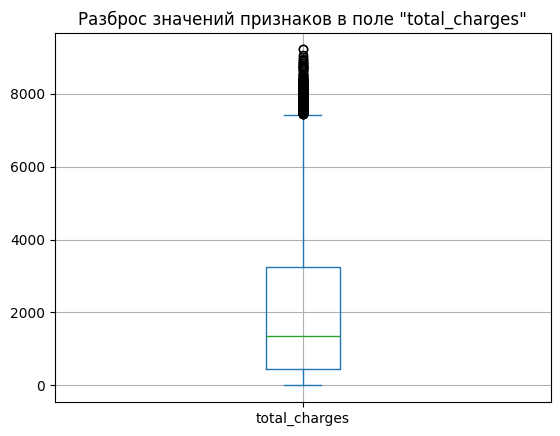

In [16]:
numeric_graph(df_contract, ['monthly_charges', 'total_charges'])

Распределение ежемесячных платежей отлично от нормального, но вполне объяснимо и не содержит явных аномалий (значительных выбросов или отрицательных значений). Преобладают клиенты с базовой недорогой подпиской, остальные распределены примерно равномерно по пакетам с доп.услугами.

Накопительная сумма демонстрирует распределение с длинным хвостом, который формируется из лояльных "долгоживущих" абонентов. Основная часть приносит умеренный совокупный доход.

Суммируя, **портрет типичного абонента компании "ТелеДом"** - это одинокий (холостой) человек не пенсионного возраста, проживающий в малом домохозяйстве, с умеренными и предсказуемыми расходами на телеком-услуги. Его ежемесячный платеж находится в среднем диапазоне, что отражает базовый пакет услуг без излишеств. При этом совокупные расходы за все время обслуживания остаются невысокими, что характерно для клиентов с относительно недолгим сроком жизни в компании. Основная услуга — быстрый интернет (оптоволокно), а из допопций используется минимум: телефония обычно ограничивается одной линией, редко подключаются услуги безопасности или техподдержки, с вероятностью 50/50 присутствует ТВ-пакет.

Он пользуется помесячным договором и предпочитает цифровые форматы взаимодействия: перешел на электронные счета, но платит вручную через чеки, ежемесячно подтверждая свое решение об обслуживании. Это создает риски оттока, но одновременно открывает возможности для дополнительного контакта и удержания.

Рассмотрим количество контрактов по дате заключения. 

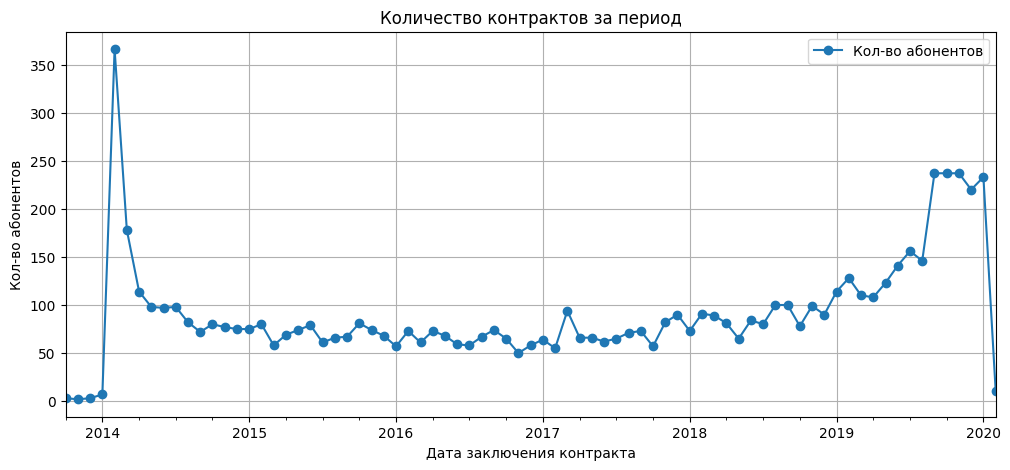

In [17]:
(df_contract.pivot_table(index='begin_date', 
                         values='customer_id', 
                         aggfunc='count')
            .sort_values(by='begin_date', ascending=True)
            .rename(columns={'begin_date': 'Дата заключения контракта',
                             'customer_id': 'Кол-во абонентов'})
            .plot(xlabel='Дата заключения контракта', ylabel='Кол-во абонентов',
                  grid=True, style='o-', figsize=(12, 5), 
                  title='Количество контрактов за период')
);

Динамика заключения контрактов демонстрирует три четких этапа развития бизнеса:

1.  **Стартовый период (конец 2013 - начало 2014)**
Резкий пик подключений свидетельствует об успешном запуске компании или масштабной маркетинговой кампании. Этот "пусковой" эффект мог быть вызван выходом на рынок или новый регион, запуском нового продукта или агрессивной акционной политикой.

2. **Стабилизация (2014-2017)**
Стабильный приток на уровне 60-90 подключений в месяц. Судя по всему, это базовая деятельность компании без значительного маркетингового стимулирования.

3. **Этап роста (середина 2018-2019)**
Поступательный рост до 150-240 подключений ежемесячно свидетельствует о росте компании. Такой динамичный рост мог быть достигнут за счет расширения зоны покрытия, внедрения пакетных предложений или маркетинговой компании. На период резкого роста приходится начало пандемии - возможно, люди стали больше находиться дома и активнее использовать интернет.

Обрыв данных в начале 2020 года не отражает реальное состояние спроса, т.к.последний период может быть не полным.


Для дальнейшего анализа нам предварительно необходимо объединить данные. В качестве исходной таблицы используем данные по контрактам, к ней присоединим остальные "слева". Возникшие пропущенные значения заполним ранее оговоренными "заглушками" - 'NO_INTERNET_SERVICE', 'NO_PHONE_SERVICE'. Т.к. все признаки в таблицах по интернету и телефонии категориальные, мы можем так поступить.

Пропуски в дате окончания договора заполним "текущей" датой.

In [12]:
df_full = (
    df_contract
    .merge(df_personal, on="customer_id", how="left")
    .merge(df_internet, on="customer_id", how="left")
    .merge(df_phone, on="customer_id", how="left")
)

df_full.shape

(7043, 21)

In [13]:
inet_cols = df_internet.columns.drop('customer_id').tolist()

for col in inet_cols:
    df_full[col] = df_full[col].fillna('NO_INTERNET_SERVICE')
    
df_full['multiple_lines'] = df_full['multiple_lines'].fillna('NO_PHONE_SERVICE')

df_full['end_date'] = df_full['end_date'].fillna(CONTROL_DATE)

In [20]:
df_full.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
target               0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

Все пропуски в данных устранены. 

Сформируем новые признаки, которые могут быть полезны в дальнейшем анализе и обучении:
- продолжительность контракта в днях
- количество подключенных интернет-услуг
- бинарная переменная, которая отражает полный пакет подключенных услуг
- лояльность клиента (продолжительность контракта более трех лет)

In [14]:
# Продолжительность контракта
df_full['contract_duration'] = (df_full['end_date'] - df_full['begin_date']).dt.days

# Количество подключенных интернет-услуг
inet_cols = df_internet.columns.drop(['customer_id', 'internet_service']).tolist()
df_full['internet_services_count'] = df_full[inet_cols].apply(lambda x: (x == 'Yes').sum(), axis=1)

# Имеет ли полный пакет интернет-услуг
df_full['full_internet_package'] = (df_full['internet_services_count'] == len(inet_cols)).astype(int).astype(str)

# Лояльность (долгосрочный клиент)
df_full['is_long_term_client'] = (df_full['contract_duration'] > 365*3).astype(int).astype(str) 

Мы создали производный от дат начала и окончания контракта признак - продолжительность контракта, который характеризует поведение и лояльность клиента. Сами по себе даты лишь фиксируют факт подключения и не дают полезной информации для модели. К тому же, даты могут приводить к переобучению (за счет улавливания исторических паттернов вместо реальных причин оттока), поэтому их можно сразу исключить из дальнейшего анализа и обучения.

In [15]:
df_full = df_full.drop(columns=['end_date', 'begin_date'])

Визуализируем соотношение ушедших и оставшихся клиентов для каждого признака. Для этого построим вертикальные столбчатые диаграммы для каждого категориального признака. Т.к. ушедших клиентов значительно меньше, чем оставшихся, при сравнении абсолютных чисел мы сталкиваемся с разным размером групп. Это искажает визуальное восприятие: даже если распределение по категориям одинаковое, столбцы будут разной высоты. Поэтому выведем сравнительный результат в долях, что обеспечит сопоставимость данных.

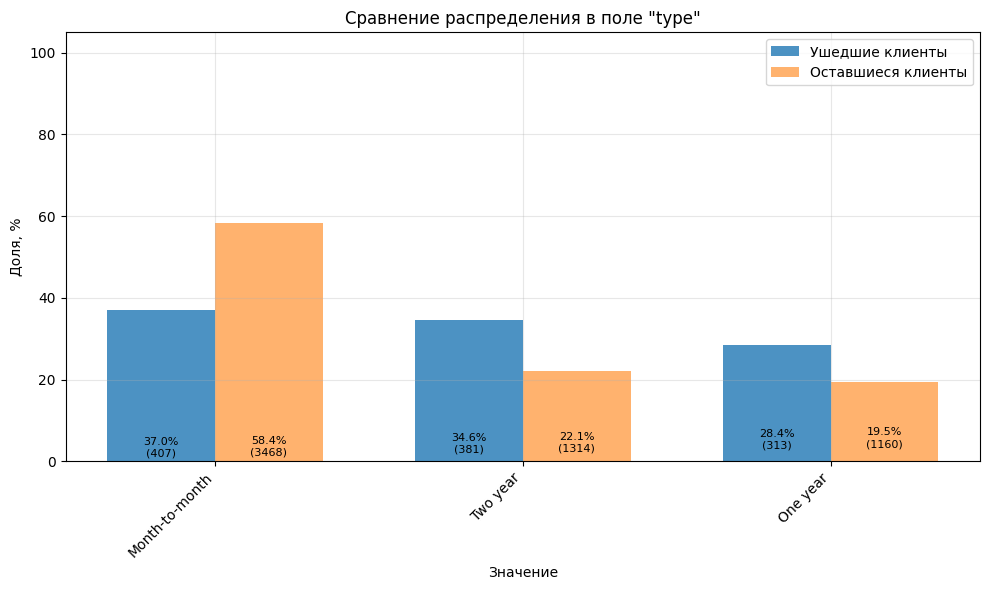

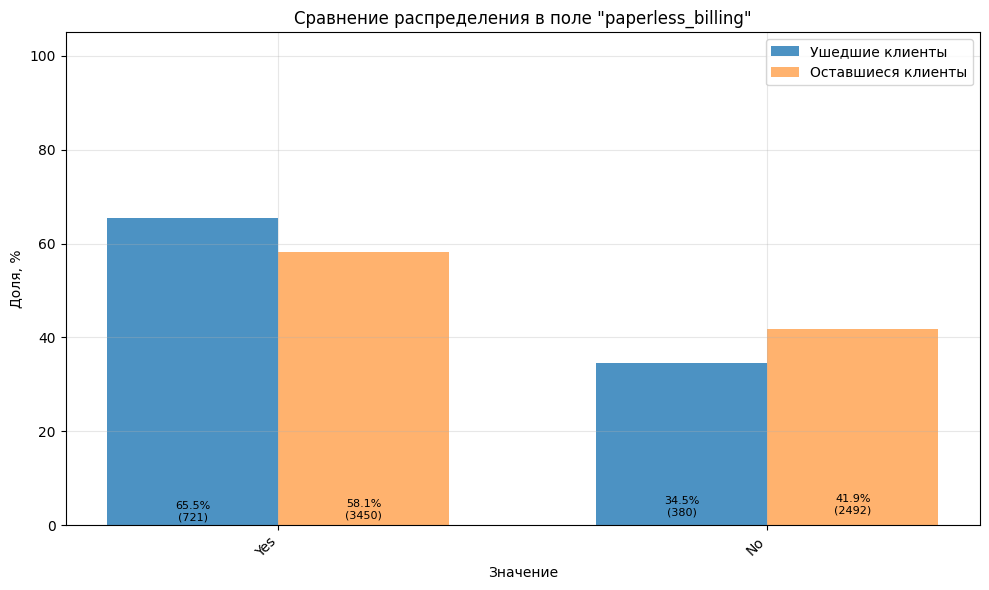

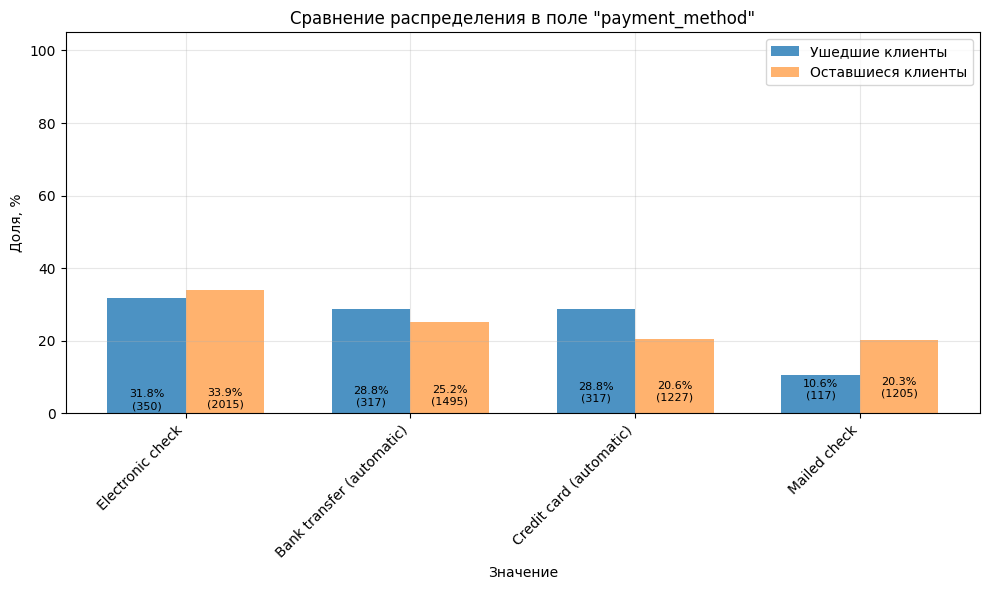

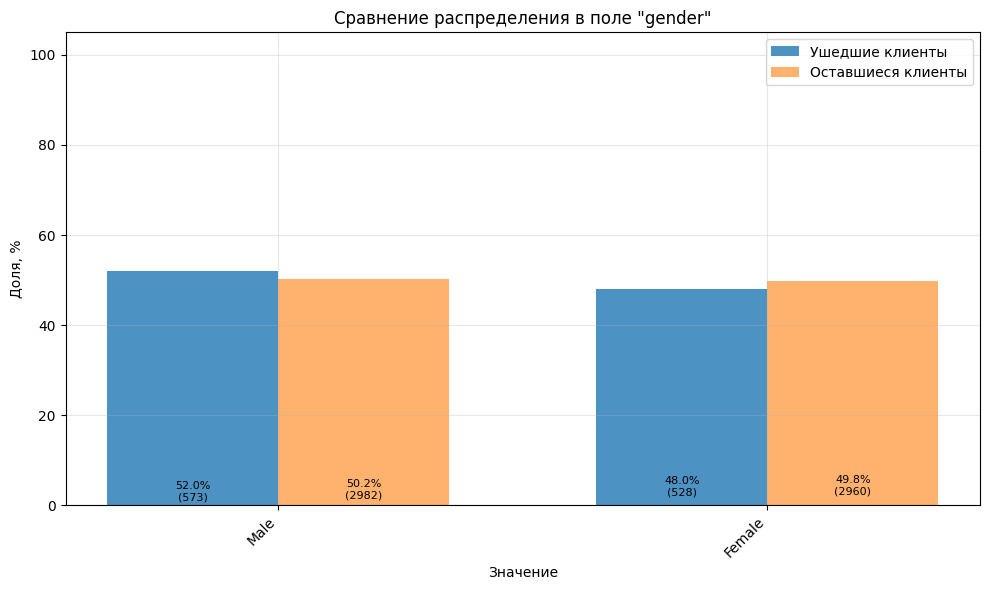

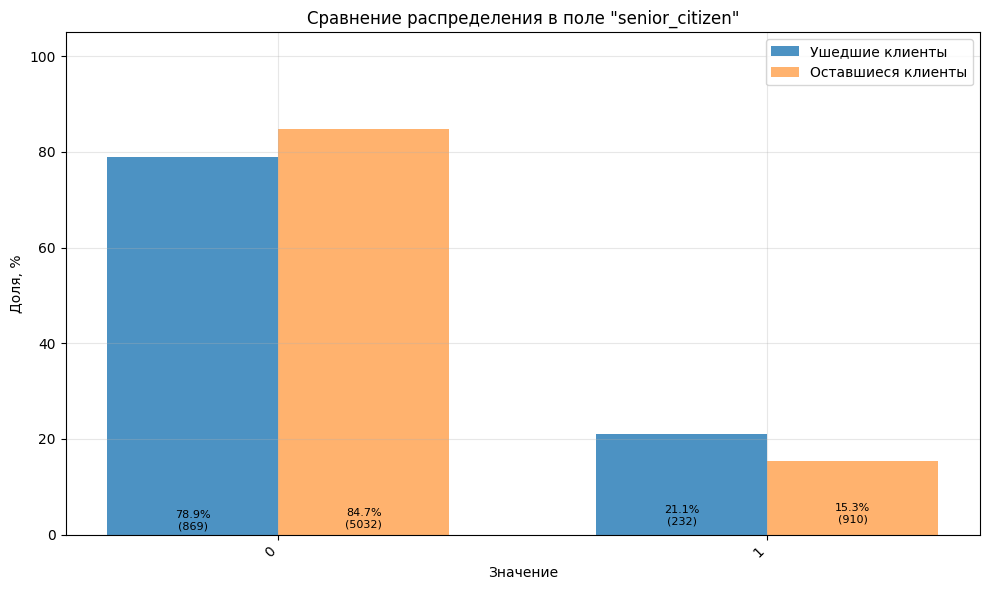

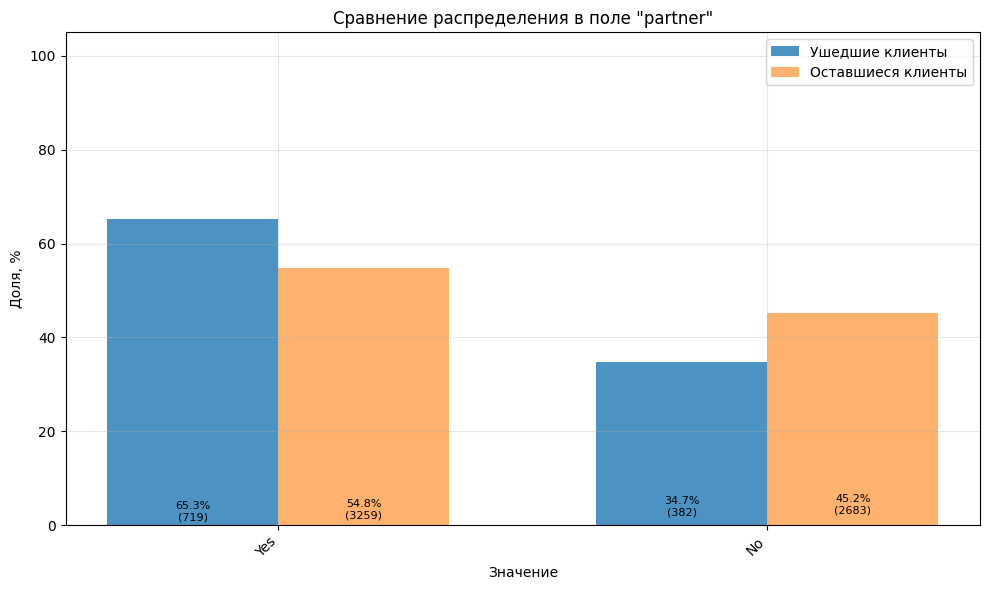

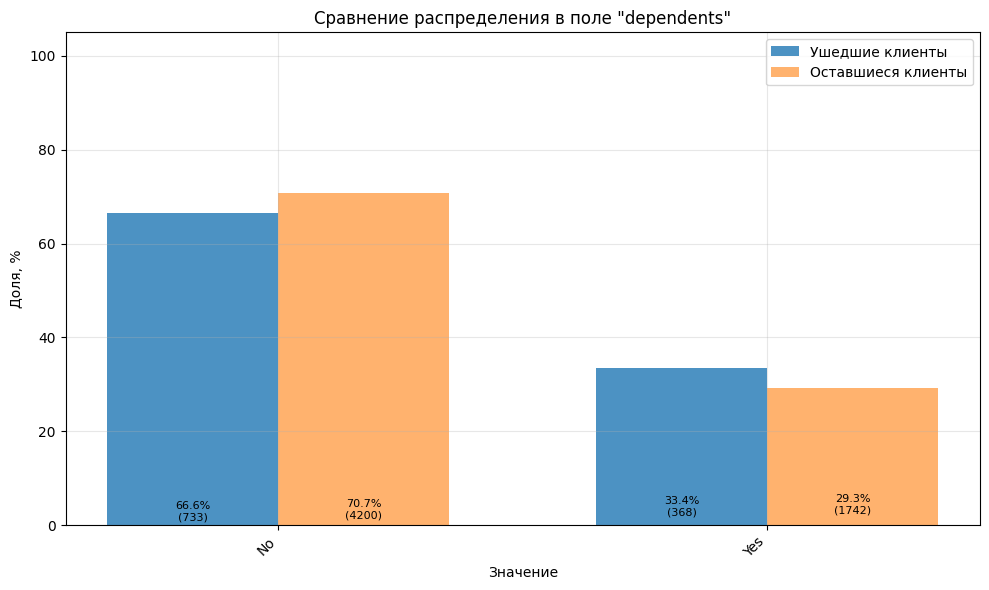

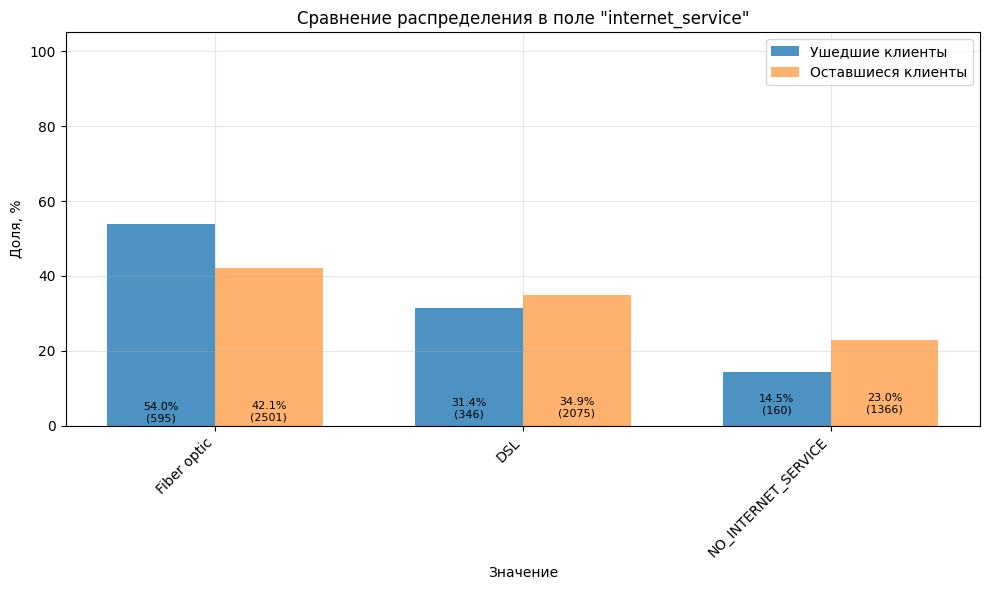

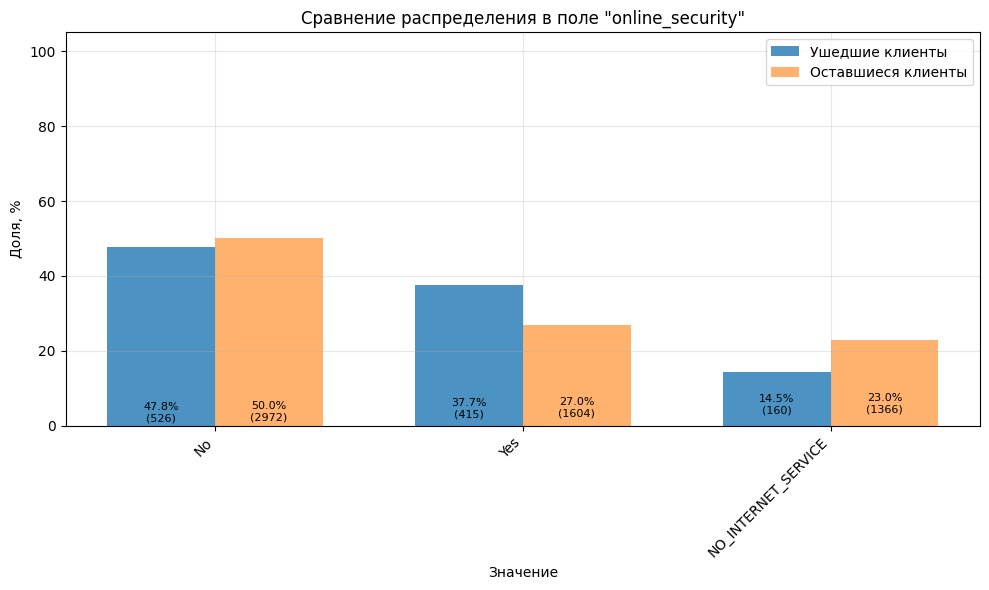

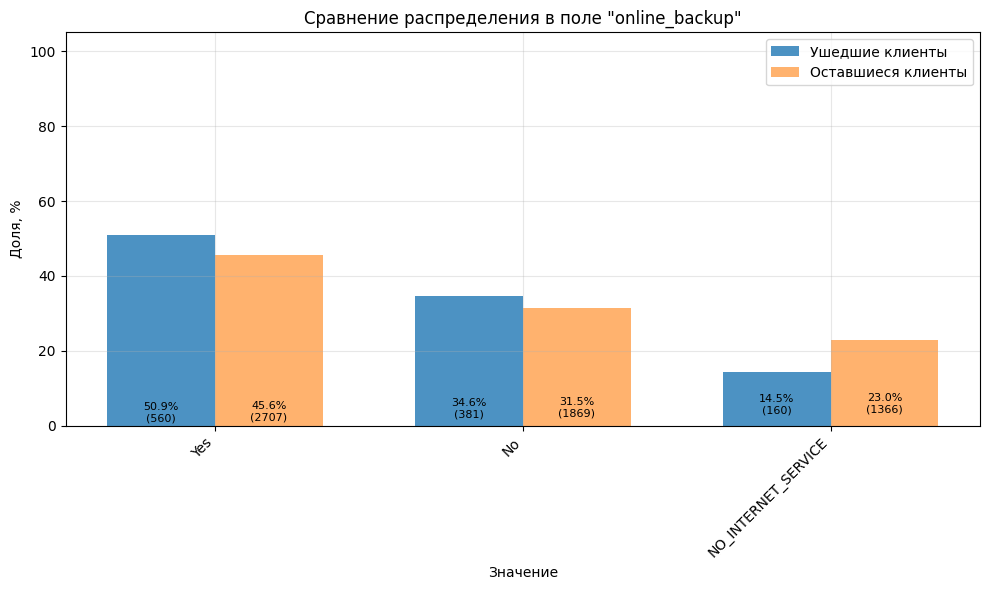

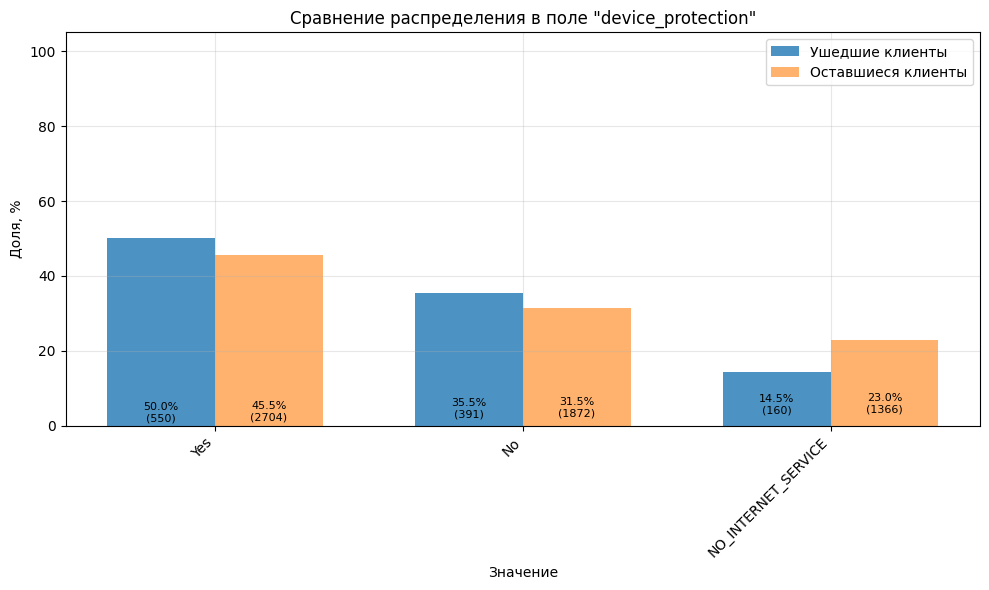

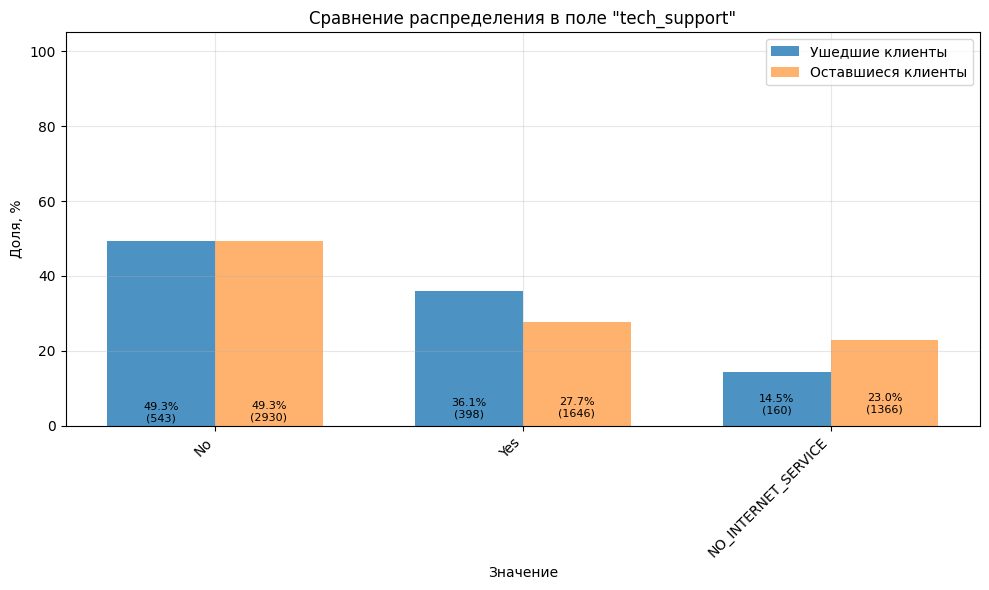

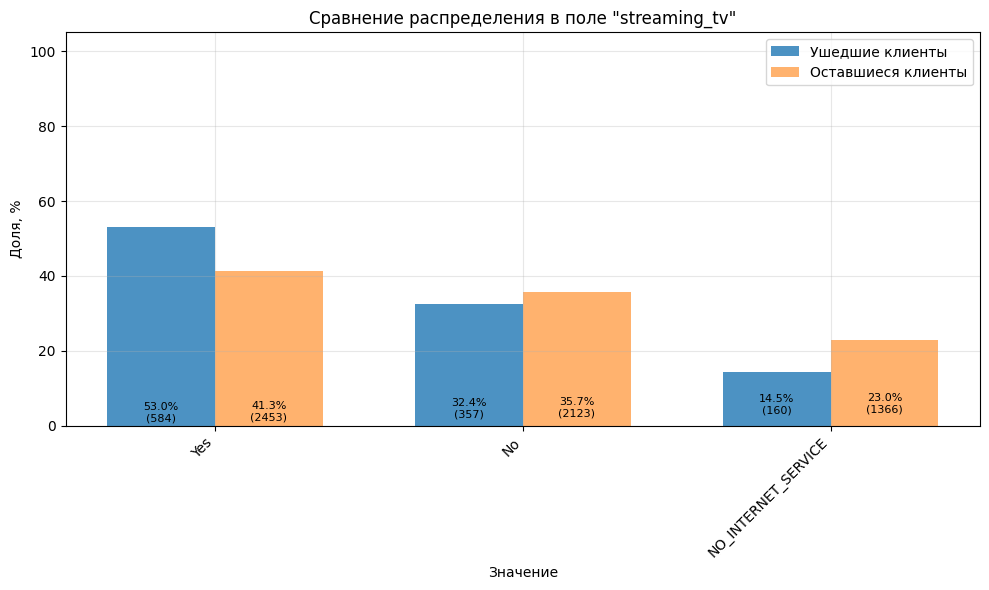

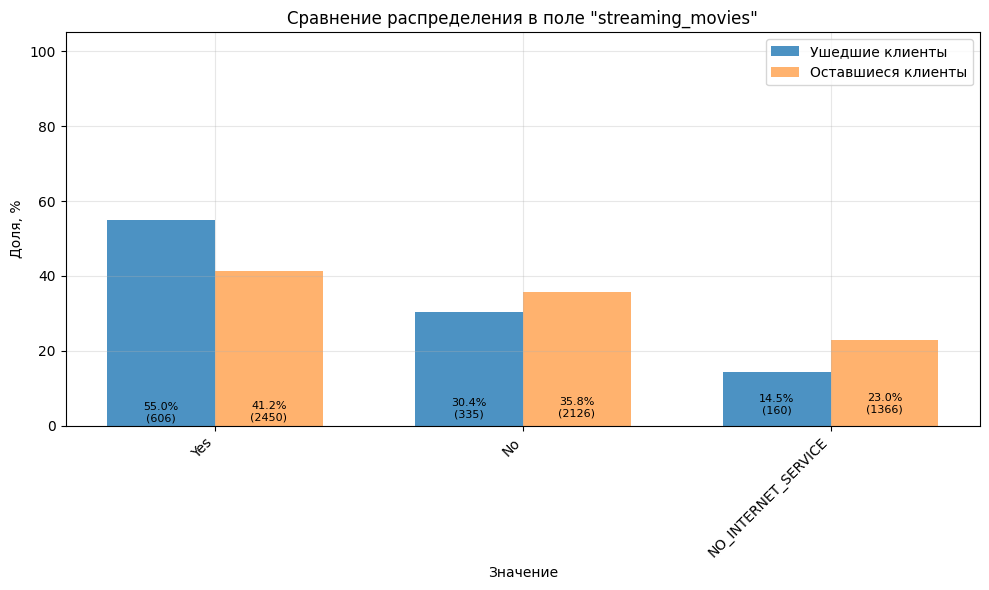

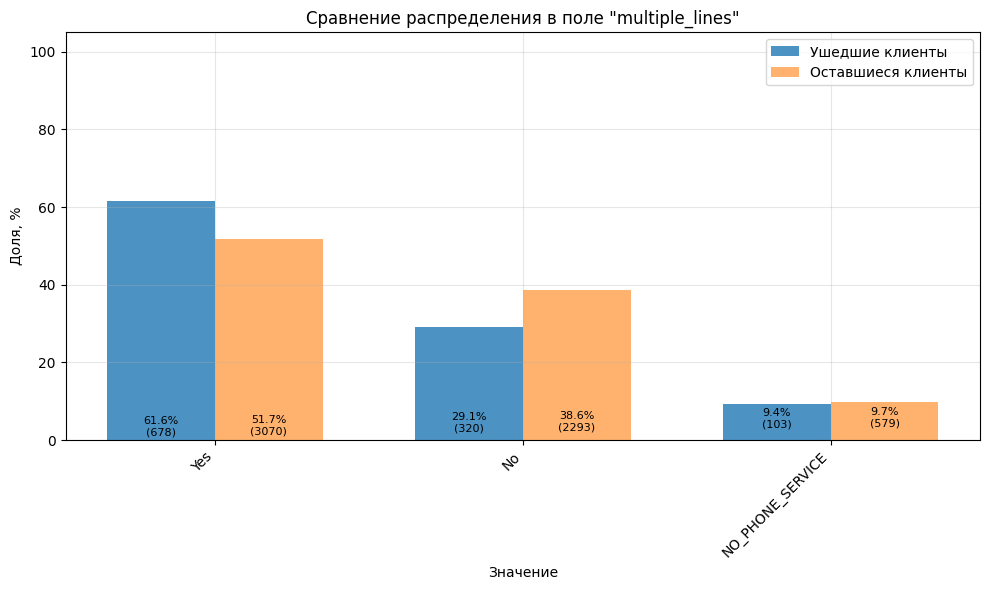

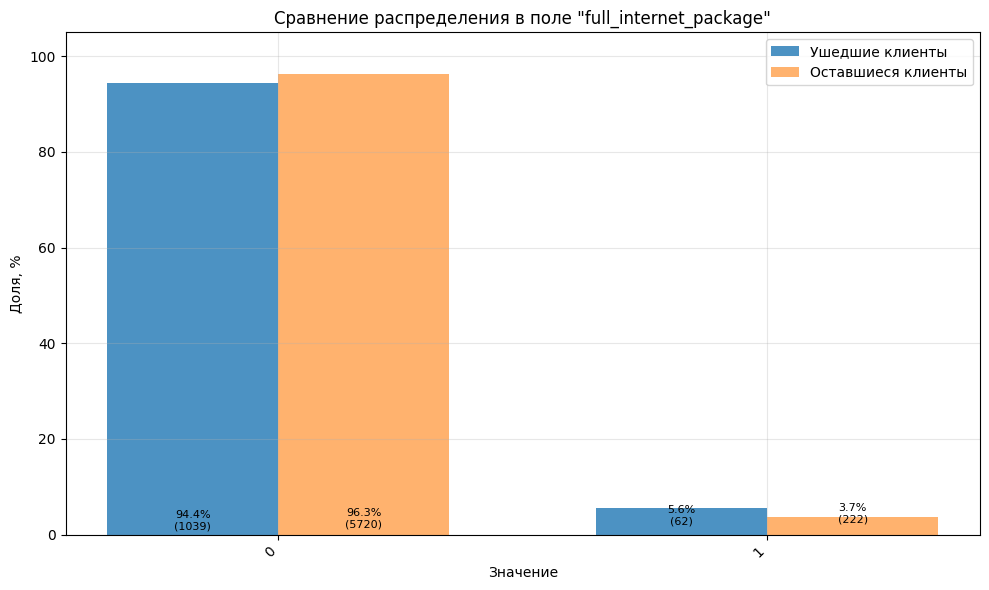

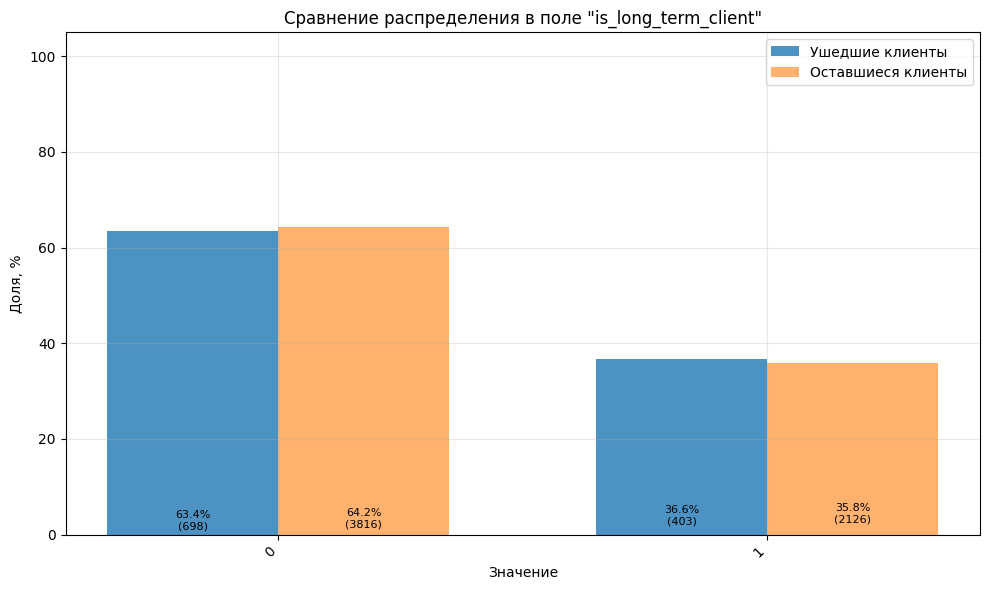

In [16]:
cat_columns = df_full.select_dtypes(exclude='number').columns.drop(['customer_id']).tolist()
category_graph_compare(df_full, cat_columns)

Проанализируем распределения с точки зрения выявления ключевых факторов, влияющих на отток клиентов. 

1. Наиболее значимые различия наблюдаются в **типах контрактов**, где клиенты с помесячными договорами демонстрируют на 21.4% меньшую долю среди ушедших, в то время как долгосрочные контракты показывают обратную тенденцию — двухгодичные и годичные договоры имеют положительную разницу в 12.5% и 8.9% соответственно. Это укладывается в логику: чем дороже пакет и выше ожидания к качеству, тем выше вероятность уйти при неудовлетворённости ценой или сервисом. В дополнение доля ушедших немного выше среди тех, кто оплачивал услуги автоматически и получал электроннеы платежки.

2. Среди персональных данных доля ушедших выше у клиентов в браке (на 8,5%). Пенсионеры и клиенты с детьми показывают немного большую долю уходов, но разница невелика.

3. На оптике ('fiber optic') доля уходов выше, чем на 'DSL'. Подключение **допуслуг — безопасность, бэкап, техподдержка, стриминг** — сопровождается более высокой долей оттока по сравнению с отсутствием этих услуг, что согласуется с эффектом «дорогого» пакета и высоких ожиданий.

4. Абоненты с **несколькими телефонными линиями** уходят чаще, чем с одной. 

Суммарно больше всего уходит «дорогой» сегмент — оптика, несколько подключённых сервисов, высокий ежемесячный платёж, фиксированный договор в зоне 1–3 лет стажа. Именно этим группам стоит первыми показывать удерживающие офферы перед окончанием срока и предлагать оптимизацию пакета/цены.

Рассмотрим распределение количественных переменных среди ушедших и оставшихся клиентов. Выборки разного размера, поэтому для следующего графика используем параметр "density=True". Так нам удастся автоматически перейти от количества к доле.

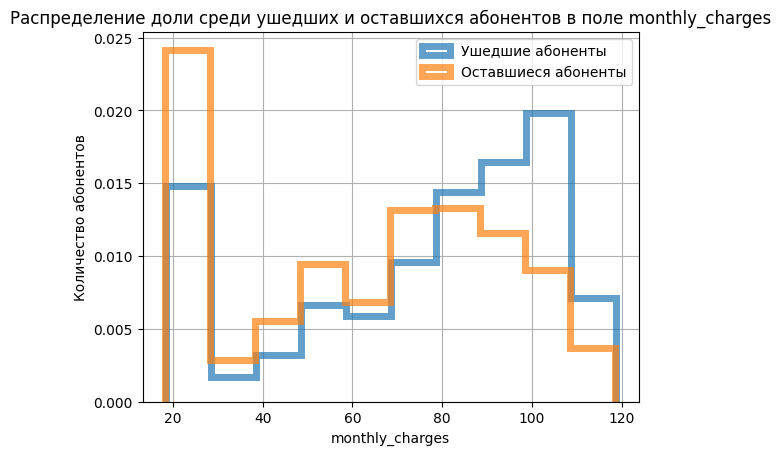

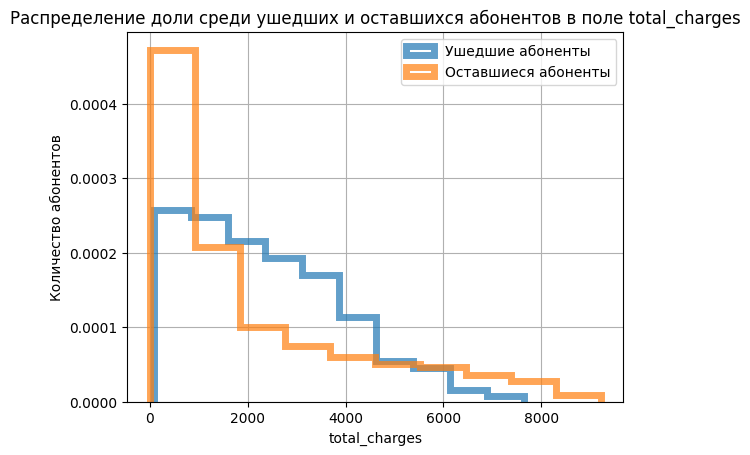

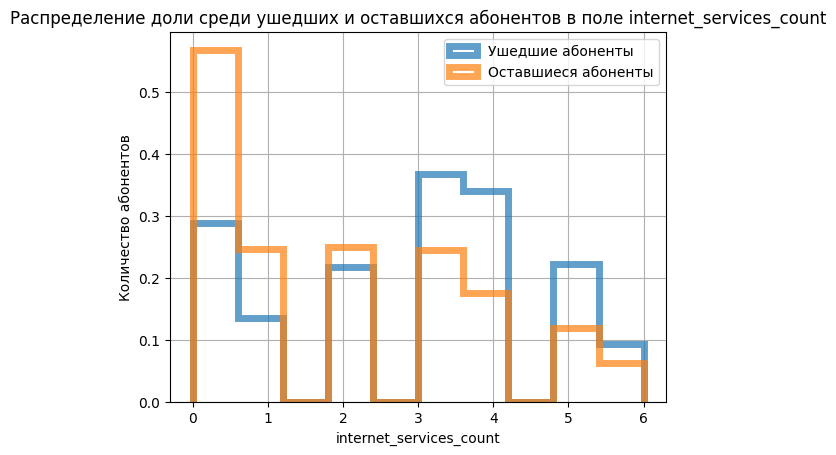

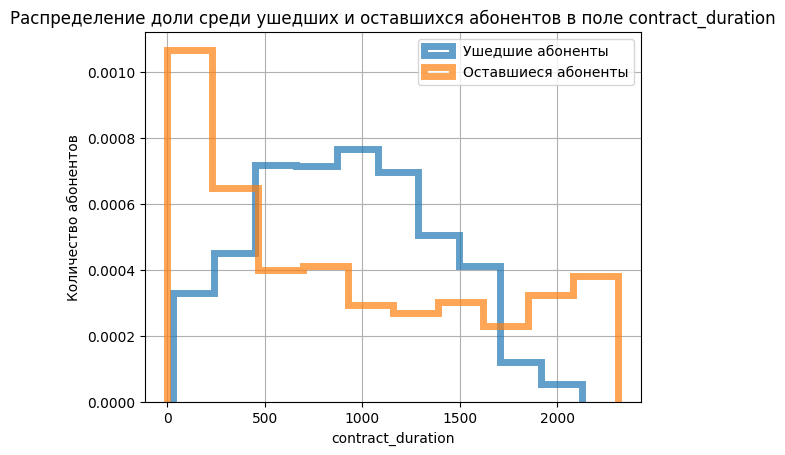

In [17]:
num_cols = ['monthly_charges', 'total_charges', 'internet_services_count', 'contract_duration']
numeric_graph_compare(df_full, num_cols)

1. С ростом ежемесячного платежа доля ушедших клиентов стабильно увеличивается: низкие тарифы удерживаются лучше, а среди клиентов с платежом 95–110 ден.единиц доля уходов максимальная. По накопленному чеку отток выше в средних значениях (порядка 1,5 – 4 тыс.), а на самых больших суммах снова падает — «старые» клиенты устойчивее.

2. Самые уязвимые к уходу — клиенты со стажем примерно от года до четырёх лет. Совсем «свежие» и «долго живущие» уходят заметно реже. По числу интернет-услуг риск растет по мере увеличения количества услуг.

Итого согласно анализа, **ключевыми предикторами оттока** являются тип контракта с выраженным риском долгосрочных договоров, стоимость ежемесячного платежа, стаж клиента в диапазоне 12-48 месяцев, наличие оптоволоконного интернета, количество подключенных дополнительных услуг и несколько телефонных линий. 

**Типичный ушедший клиент** — это состоятельный пользователь премиальных услуг, который изначально выбрал компанию для получения высококачественного сервиса, но столкнулся с несоответствием ожиданий. Это клиент с годовым или двухгодичным контрактом, использующий оптический интернет и несколько дополнительных услуг — безопасность, резервное копирование, стриминг и несколько телефонных линий. Его ежемесячные платежи находятся в верхнем ценовом сегменте, а общая сумма накопленных платежей составляет 1,5-4 тысячи денежных единиц. Наиболее критичный период для такого клиента — от года до четырех лет обслуживания, когда первоначальные ожидания сталкиваются с реальным опытом использования услуг. При этом он предпочитает современные способы взаимодействия — автоматические платежи и электронные счета, что свидетельствует о его цифровой грамотности и требовательности к сервису.

Дополнительно проведем корреляционный анализ переменных, чтобы отобрать переменные и улучшить понимание о возможных связях между целевой переменной и признаками. Т.к. у нас в данных есть как количественные так и категориальные признаки, используем коэффициент корреляции Фи. Для наглядности построим тепловую карту.

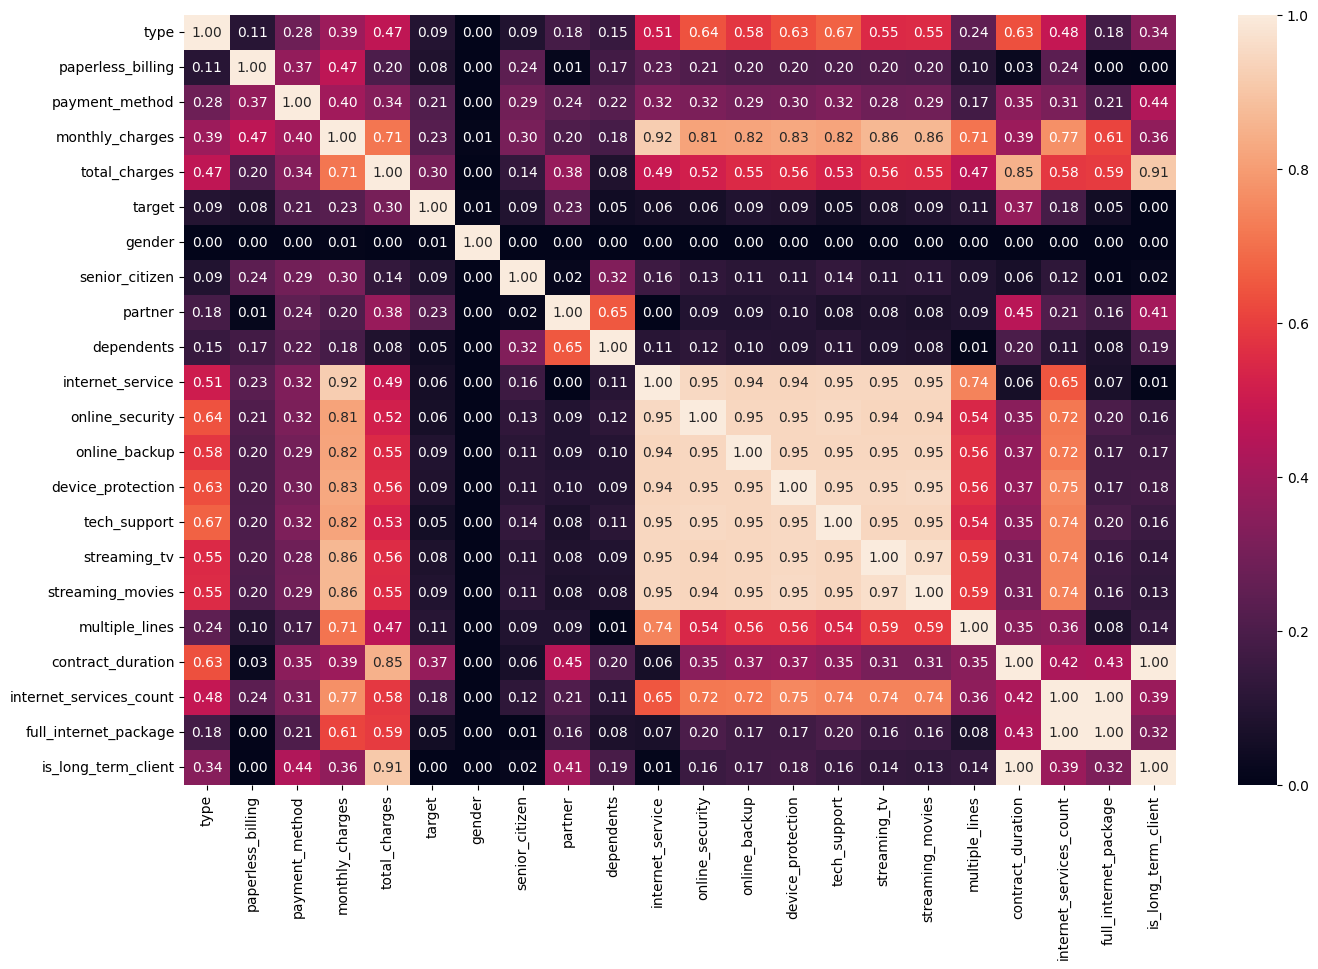

In [18]:
df_corr = df_full.drop(columns=['customer_id']).copy()
plt.figure(figsize=(16, 10))
sns.heatmap(df_corr.phik_matrix(interval_cols=num_cols), annot=True, fmt='.2f')
plt.show();

1. У нас есть ряд мультиколлинеарных признаков (значение коэффициента > 0.9): группа интернет-услуг сильно коррелирует между собой. Вместо них можно использовать агрегированный признак `internet_services_package`, т.к. на этапе анализа мы отметили его как информативный по отношению к количеству ушедших пользователей. Коррелирующий с ним `full_internet_package` удалим. 

2. Также `internet_service` сильно коррелирует с полем `monthly_charges` - тип подключения и наличие интернет-услуг влияют на ежемесячный платеж. Т.к. `monthly_charges` имеет более высокую корреляцию с целевым признаком, оставим его.

3. Поле `is_long_term_client`, подготовленное для удобства анализа, исключим в пользу более информативного `contract_duration`. На инференсе для расчета этой переменной можно использовать текущую дату,к тому же наличие умеренной кореляции по шкале Чеддока (0,37) с целевой переменной говорит в пользу этой переменной.

Оставшиеся переменные у которых значение коэффициента < 0.9 оставим в данных. 

Самая сильная корреляция (умеренная по шкале Чеддока) у целевого признака с переменной `contract_duration` (0,37) и `total_charges`(0,3). Остальные признаки имеют слабую корреляцию.

Перед дальнейшей подготовкой данных исключим отобранные колонки из датасета. Также удалим колонку с ID, т.к. она не требуется при обучении. Дополнительно проверим данные на наличие явных дубликатов без ID: одинаковые строки не информативны дял модели.

In [19]:
cols_to_drop = inet_cols + ['full_internet_package', 'internet_service', 'is_long_term_client', 'customer_id']
df_full.drop(columns=cols_to_drop, inplace=True)

print('Размер датасета до удаления дубликатов:', df_full.shape)
df_full = df_full.drop_duplicates()
print('Размер датасета после удаления дубликатов:', df_full.shape)

Размер датасета до удаления дубликатов: (7043, 13)
Размер датасета после удаления дубликатов: (7038, 13)


<b>Вывод по разделу "Исследовательский анализ данных"</b>

В ходе анализа выявлено:
- отсутствие значимых аномалий и выбросов в количественных данных
- распределения количественных признаков отличаются от нормального
- данные требуют предварительной обработки и масштабирования перед построением моделей

1. На основе выявленных закономерностей сформирован **портрет типичного абонента компании** - это одинокий человек не пенсионного возраста, проживающий в малом домохозяйстве, с умеренными расходами на телеком-услуги. Он использует базовый пакет услуг с оптоволоконным интернетом, ограниченным набором дополнительных услуг и помесячным договором, предпочитая цифровые форматы взаимодействия, но сохраняя ручной контроль над платежами.

2. Для углубленного анализа данные были объединены и дополнены производными признаками, включая продолжительность контракта, количество подключенных интернет-услуг и индикаторы лояльности клиентов. При этом исключены потенциально проблемные признаки, такие как 'сырые' даты, которые могут приводить к переобучению моделей.

3. Ключевыми предикторами оттока определены тип контракта, стоимость ежемесячного платежа, стаж клиента в диапазоне 12-48 месяцев, наличие оптоволоконного интернета, количество дополнительных услуг и несколько телефонных линий. Типичный ушедший клиент представляет собой платежеспособного пользователя премиальных услуг, столкнувшегося с несоответствием ожиданий от сервиса.

4. Корреляционный анализ выявил наличие мультиколлинеарности среди группы интернет-услуг, что требует консолидации этих признаков. Наибольшую корреляцию с целевой переменной демонстрируют продолжительность контракта и общая сумма платежей. Для дальнейшего моделирования исключены дублирующие и сильно коррелирующие признаки.

## Подготовка данных и разработка модели

Т.к. ранее мы отметили, что в целевой переменной присутствует дисбаланс классов, при разбиении данных будем использовать стратифицированные выборки.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    df_full.drop(columns=['target'], axis=1),
    df_full['target'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_full['target'])

Переходим к подготовке пайплайна для предобработки признаков. Подготовим списки с названиями признаков, разделенные по предполагаемому методу обработки. Бинарные и категориальные признаки закодируем с помощью one-hot. Количественные признаки - расходы, продолжительность контракта и кол-во подключенных услуг имеют различные диапазоны значений, поэтому применим к данным масштабирование с помощью метода MinMaxScaler для деревянных моделей.

In [21]:
ohe_columns = ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner', \
                         'dependents', 'multiple_lines']
num_columns = ['monthly_charges', 'total_charges', 'contract_duration', 'internet_services_count']

Пайплайн дополним обработкой пропущенных значений энкодерами. Для энкодеров установим параметр handle_unknown, который позволяет обрабатывать неизвестные категории при необходимости и присваивать им нулевое значение. 

In [32]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 

Создаем общий пайплайн для подготовки данных: применяем каждый ранее созданный пайплайн к соответствующим колонкам. К количественным признакам применяем масштабирование. Этот же пайплайн `data_preprocessor` будем в дальнейшем использовать для предобработки данных перед подачей в полносвязную нейронную сеть.

In [33]:
data_preprocessor = ColumnTransformer(
    [ 
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

Подготовим пайплан для обучения моделей. Итоговый пайплайн включает 2 шага: 

1. Подготовка данных — шаг preprocessor.
2. Инициализация модели DecisionTreeClassifier — шаг models.

In [142]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier())
    ]
) 


Чтобы найти лучшее решение обучим для начала 3 разных классических модели ML. Согласно ТЗ это должны быть решающее дерево или случайный лес и бустинги. Нейросеть обучим на следующем этапе. 

Обучим:
- DecisionTreeClassifier() - решающее дерево
- LGBMClassifier() и CatBoostClassifier() - бустинги

Для моделей подберем гиперпараметры. Т.к. мы планируем использовать нейросеть, я бы отказалась отиспользования кросс-валидации и стандартных методов перебора параметров, чтобы сравнивать величину метрики у моделей в одинаковых условиях. Но по ТЗ нам необходимо использовать методы автоматизированного подбора гиперпараметров. Для моделей в этом разделе используем GridSearchCV, а для нейросети - optuna.

Дл масштабирования в деревянной модели попробуем использовать два скейлера: `StandardScaler()` и `MinMaxScaler()` + без масштабирования. Зададим варианты масшабирования как гиперпараметр.

In [143]:
param_grid = [
    # DecisionTreeClassifier
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__max_depth': [5, 8, None],
        'models__min_samples_leaf': [1, 5],
        'models__min_samples_split': [2, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    },

    # LightGBM 
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1,
                                 subsample=1.0, 
                                 colsample_bytree=0.8)],
        'models__n_estimators': [400, 600],
        'models__learning_rate': [0.05, 0.1],
        'models__num_leaves': [15, 30],
        'models__max_depth': [8, 16],
        'preprocessor__num': ['passthrough'],  
    },

    # CatBoost
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)],
        'models__iterations': [500, 1000],
        'models__learning_rate': [0.03, 0.1],
        'models__depth': [4, 6],
        'models__l2_leaf_reg': [3, 5],
        'preprocessor__num': ['passthrough'],
    },
]


В качестве метрики используем **ROC-AUC** согласно ТЗ. Эта метрика хорошо подходит для сравнения качества различных алгоритмов. Она оценивает качество решений модели в наиболее общем виде, учитывая все возможные пороговые значения.

In [144]:
grid_search = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=3
)

In [145]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 68 candidates, totalling 340 fits
[CV 1/5] END models=DecisionTreeClassifier(class_weight='balanced', random_state=51125), models__max_depth=5, models__min_samples_leaf=1, models__min_samples_split=2, preprocessor__num=StandardScaler();, score=0.793 total time=   0.1s
[CV 2/5] END models=DecisionTreeClassifier(class_weight='balanced', random_state=51125), models__max_depth=5, models__min_samples_leaf=1, models__min_samples_split=2, preprocessor__num=StandardScaler();, score=0.789 total time=   0.1s
[CV 3/5] END models=DecisionTreeClassifier(class_weight='balanced', random_state=51125), models__max_depth=5, models__min_samples_leaf=1, models__min_samples_split=2, preprocessor__num=StandardScaler();, score=0.787 total time=   0.1s
[CV 4/5] END models=DecisionTreeClassifier(class_weight='balanced', random_state=51125), models__max_depth=5, models__min_samples_leaf=1, models__min_samples_split=2, preprocessor__num=StandardScaler();, score=0.775 total time=   0.1

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=8, models__n_estimators=400, models__num_leaves=15, preprocessor__num=passthrough;, score=0.903 total time=   2.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=8, models__n_estimators=400, models__num_leaves=15, preprocessor__num=passthrough;, score=0.891 total time=   2.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=8, models__n_estimators=400, models__num_leaves=15, preprocessor__num=passthrough;, score=0.859 total time=   2.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=8, models__n_estimators=400, models__num_leaves=15, preprocessor__num=passthrough;, score=0.884 total time=   2.5s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=8, models__n_estimators=400, models__num_leaves=15, preprocessor__num=passthrough;, score=0.910 total time=   2.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=8, models__n_estimators=400, models__num_leaves=30, preprocessor__num=passthrough;, score=0.902 total time=   3.4s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=8, models__n_estimators=400, models__num_leaves=30, preprocessor__num=passthrough;, score=0.904 total time=   3.5s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=8, models__n_estimators=400, models__num_leaves=30, preprocessor__num=passthrough;, score=0.865 total time=   3.5s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=8, models__n_estimators=400, models__num_leaves=30, preprocessor__num=passthrough;, score=0.882 total time=   3.4s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=8, models__n_estimators=400, models__num_leaves=30, preprocessor__num=passthrough;, score=0.905 total time=   3.4s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=8, models__n_estimators=600, models__num_leaves=15, preprocessor__num=passthrough;, score=0.906 total time=   3.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=8, models__n_estimators=600, models__num_leaves=15, preprocessor__num=passthrough;, score=0.898 total time=   3.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=8, models__n_estimators=600, models__num_leaves=15, preprocessor__num=passthrough;, score=0.867 total time=   3.4s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=8, models__n_estimators=600, models__num_leaves=15, preprocessor__num=passthrough;, score=0.885 total time=   4.5s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=8, models__n_estimators=600, models__num_leaves=15, preprocessor__num=passthrough;, score=0.915 total time=   3.0s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=8, models__n_estimators=600, models__num_leaves=30, preprocessor__num=passthrough;, score=0.902 total time=   5.0s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=8, models__n_estimators=600, models__num_leaves=30, preprocessor__num=passthrough;, score=0.908 total time=   5.0s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=8, models__n_estimators=600, models__num_leaves=30, preprocessor__num=passthrough;, score=0.866 total time=   5.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=8, models__n_estimators=600, models__num_leaves=30, preprocessor__num=passthrough;, score=0.884 total time=   5.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=8, models__n_estimators=600, models__num_leaves=30, preprocessor__num=passthrough;, score=0.908 total time=   5.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=16, models__n_estimators=400, models__num_leaves=15, preprocessor__num=passthrough;, score=0.906 total time=   2.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=16, models__n_estimators=400, models__num_leaves=15, preprocessor__num=passthrough;, score=0.893 total time=   2.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=16, models__n_estimators=400, models__num_leaves=15, preprocessor__num=passthrough;, score=0.857 total time=   2.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=16, models__n_estimators=400, models__num_leaves=15, preprocessor__num=passthrough;, score=0.888 total time=   2.4s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=16, models__n_estimators=400, models__num_leaves=15, preprocessor__num=passthrough;, score=0.907 total time=   2.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=16, models__n_estimators=400, models__num_leaves=30, preprocessor__num=passthrough;, score=0.906 total time=   3.7s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=16, models__n_estimators=400, models__num_leaves=30, preprocessor__num=passthrough;, score=0.897 total time=   3.9s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=16, models__n_estimators=400, models__num_leaves=30, preprocessor__num=passthrough;, score=0.860 total time=   4.0s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=16, models__n_estimators=400, models__num_leaves=30, preprocessor__num=passthrough;, score=0.877 total time=   3.9s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=16, models__n_estimators=400, models__num_leaves=30, preprocessor__num=passthrough;, score=0.904 total time=   3.8s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=16, models__n_estimators=600, models__num_leaves=15, preprocessor__num=passthrough;, score=0.912 total time=   3.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=16, models__n_estimators=600, models__num_leaves=15, preprocessor__num=passthrough;, score=0.902 total time=   3.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=16, models__n_estimators=600, models__num_leaves=15, preprocessor__num=passthrough;, score=0.866 total time=   3.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=16, models__n_estimators=600, models__num_leaves=15, preprocessor__num=passthrough;, score=0.889 total time=   3.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=16, models__n_estimators=600, models__num_leaves=15, preprocessor__num=passthrough;, score=0.916 total time=   3.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=16, models__n_estimators=600, models__num_leaves=30, preprocessor__num=passthrough;, score=0.908 total time=   5.8s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=16, models__n_estimators=600, models__num_leaves=30, preprocessor__num=passthrough;, score=0.898 total time=   5.6s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=16, models__n_estimators=600, models__num_leaves=30, preprocessor__num=passthrough;, score=0.859 total time=   5.8s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=16, models__n_estimators=600, models__num_leaves=30, preprocessor__num=passthrough;, score=0.878 total time=   6.7s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.05, models__max_depth=16, models__n_estimators=600, models__num_leaves=30, preprocessor__num=passthrough;, score=0.902 total time=   5.5s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=8, models__n_estimators=400, models__num_leaves=15, preprocessor__num=passthrough;, score=0.909 total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=8, models__n_estimators=400, models__num_leaves=15, preprocessor__num=passthrough;, score=0.907 total time=   2.8s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=8, models__n_estimators=400, models__num_leaves=15, preprocessor__num=passthrough;, score=0.865 total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=8, models__n_estimators=400, models__num_leaves=15, preprocessor__num=passthrough;, score=0.891 total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=8, models__n_estimators=400, models__num_leaves=15, preprocessor__num=passthrough;, score=0.918 total time=   4.4s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=8, models__n_estimators=400, models__num_leaves=30, preprocessor__num=passthrough;, score=0.903 total time=   3.6s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=8, models__n_estimators=400, models__num_leaves=30, preprocessor__num=passthrough;, score=0.905 total time=   3.6s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=8, models__n_estimators=400, models__num_leaves=30, preprocessor__num=passthrough;, score=0.863 total time=   3.4s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=8, models__n_estimators=400, models__num_leaves=30, preprocessor__num=passthrough;, score=0.878 total time=   3.4s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=8, models__n_estimators=400, models__num_leaves=30, preprocessor__num=passthrough;, score=0.905 total time=   3.4s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=8, models__n_estimators=600, models__num_leaves=15, preprocessor__num=passthrough;, score=0.912 total time=   3.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=8, models__n_estimators=600, models__num_leaves=15, preprocessor__num=passthrough;, score=0.908 total time=   3.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=8, models__n_estimators=600, models__num_leaves=15, preprocessor__num=passthrough;, score=0.865 total time=   3.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=8, models__n_estimators=600, models__num_leaves=15, preprocessor__num=passthrough;, score=0.891 total time=   3.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=8, models__n_estimators=600, models__num_leaves=15, preprocessor__num=passthrough;, score=0.917 total time=   3.0s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=8, models__n_estimators=600, models__num_leaves=30, preprocessor__num=passthrough;, score=0.902 total time=   5.4s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=8, models__n_estimators=600, models__num_leaves=30, preprocessor__num=passthrough;, score=0.902 total time=   6.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=8, models__n_estimators=600, models__num_leaves=30, preprocessor__num=passthrough;, score=0.862 total time=   5.4s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=8, models__n_estimators=600, models__num_leaves=30, preprocessor__num=passthrough;, score=0.878 total time=   7.0s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=8, models__n_estimators=600, models__num_leaves=30, preprocessor__num=passthrough;, score=0.904 total time=   5.5s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=16, models__n_estimators=400, models__num_leaves=15, preprocessor__num=passthrough;, score=0.917 total time=   2.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=16, models__n_estimators=400, models__num_leaves=15, preprocessor__num=passthrough;, score=0.898 total time=   2.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=16, models__n_estimators=400, models__num_leaves=15, preprocessor__num=passthrough;, score=0.864 total time=   2.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=16, models__n_estimators=400, models__num_leaves=15, preprocessor__num=passthrough;, score=0.887 total time=   2.4s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=16, models__n_estimators=400, models__num_leaves=15, preprocessor__num=passthrough;, score=0.915 total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=16, models__n_estimators=400, models__num_leaves=30, preprocessor__num=passthrough;, score=0.903 total time=   3.8s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=16, models__n_estimators=400, models__num_leaves=30, preprocessor__num=passthrough;, score=0.900 total time=   3.9s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=16, models__n_estimators=400, models__num_leaves=30, preprocessor__num=passthrough;, score=0.861 total time=   3.9s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=16, models__n_estimators=400, models__num_leaves=30, preprocessor__num=passthrough;, score=0.876 total time=   4.0s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=16, models__n_estimators=400, models__num_leaves=30, preprocessor__num=passthrough;, score=0.905 total time=   4.0s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=16, models__n_estimators=600, models__num_leaves=15, preprocessor__num=passthrough;, score=0.918 total time=   3.4s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=16, models__n_estimators=600, models__num_leaves=15, preprocessor__num=passthrough;, score=0.902 total time=   3.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=16, models__n_estimators=600, models__num_leaves=15, preprocessor__num=passthrough;, score=0.864 total time=   3.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=16, models__n_estimators=600, models__num_leaves=15, preprocessor__num=passthrough;, score=0.890 total time=   3.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=16, models__n_estimators=600, models__num_leaves=15, preprocessor__num=passthrough;, score=0.914 total time=   3.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=16, models__n_estimators=600, models__num_leaves=30, preprocessor__num=passthrough;, score=0.905 total time=   5.8s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=16, models__n_estimators=600, models__num_leaves=30, preprocessor__num=passthrough;, score=0.900 total time=   8.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=16, models__n_estimators=600, models__num_leaves=30, preprocessor__num=passthrough;, score=0.856 total time=   5.7s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=16, models__n_estimators=600, models__num_leaves=30, preprocessor__num=passthrough;, score=0.878 total time=   5.5s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/5] END models=LGBMClassifier(colsample_bytree=0.8, random_state=51125), models__learning_rate=0.1, models__max_depth=16, models__n_estimators=600, models__num_leaves=30, preprocessor__num=passthrough;, score=0.902 total time=   5.8s
[CV 1/5] END models=<catboost.core.CatBoostClassifier object at 0x7f483cfd2c10>, models__depth=4, models__iterations=500, models__l2_leaf_reg=3, models__learning_rate=0.03, preprocessor__num=passthrough;, score=0.870 total time=   1.7s
[CV 2/5] END models=<catboost.core.CatBoostClassifier object at 0x7f483cfd2c10>, models__depth=4, models__iterations=500, models__l2_leaf_reg=3, models__learning_rate=0.03, preprocessor__num=passthrough;, score=0.866 total time=   1.5s
[CV 3/5] END models=<catboost.core.CatBoostClassifier object at 0x7f483cfd2c10>, models__depth=4, models__iterations=500, models__l2_leaf_reg=3, models__learning_rate=0.03, preprocessor__num=passthrough;, score=0.862 total time=   1.8s
[CV 4/5] END models=<catboost.core.CatBoostClassifier

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'gender',
                                                                          'senior_citizen',
                                                                          '...
                          'models__n_estimators': [400, 600],
                          'models__num_leaves': [15, 30],
                          'preprocessor__num': ['passthrough']},
                         {'models': [<catboost.core.CatBoostClassifier object at 0x7f483cfd2c10>],
                          'models__depth': [4, 6],
                          'models__iterations': [500, 1000],
                          'models__l2_leaf_reg': [3, 5],
                          'models__learning_rate': [0.03, 0.1],
                          'preprocessor__num': ['passthrough']}],
             scoring='roc_auc', verbose=3)

In [147]:
print('Метрика roc_auc для лучшей модели:\n', grid_search.best_score_)
print('\nЛучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print('\nЛучшие параметры\n\n', grid_search.best_params_)

Метрика roc_auc для лучшей модели:
 0.9176344261682441

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['type', 'paperless_billing',
                                                   'payment_method', 'gender',
                         

Проанализируем лучшие результаты для каждой из моделей.

In [148]:
results = pd.DataFrame(grid_search.cv_results_)
results['model_name'] = results['params'].apply(lambda x:type(x['models']).__name__)
results['ROC_AUC'] = results['mean_test_score']
results.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__max_depth,param_models__min_samples_leaf,param_models__min_samples_split,param_preprocessor__num,param_models__learning_rate,...,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,model_name,ROC_AUC
0,0.049754,0.000918,0.015069,0.000388,DecisionTreeClassifier(class_weight='balanced'...,5,1.0,2.0,StandardScaler(),NaN,...,0.792895,0.789249,0.787001,0.775397,0.810238,0.790956,0.01128,33,DecisionTreeClassifier,0.790956
1,0.050221,0.001778,0.016496,0.001796,DecisionTreeClassifier(class_weight='balanced'...,5,1.0,2.0,MinMaxScaler(),NaN,...,0.792895,0.789249,0.787001,0.775397,0.810238,0.790956,0.01128,33,DecisionTreeClassifier,0.790956


In [149]:
best_results_by_model = (
    results.loc[results.groupby('model_name')['ROC_AUC'].idxmax()]
    .sort_values('ROC_AUC')
)

In [193]:
summary = best_results_by_model[[
    'rank_test_score',
    'model_name',
    'ROC_AUC',
    'params'
]].reset_index(drop=True)

pd.set_option('display.max_colwidth', None)
summary

,rank_test_score,model_name,ROC_AUC,params
0,33,DecisionTreeClassifier,0.790956,"{'models': DecisionTreeClassifier(class_weight='balanced', random_state=51125), 'models__max_depth': 5, 'models__min_samples_leaf': 1, 'models__min_samples_split': 2, 'preprocessor__num': StandardScaler()}"
1,10,LGBMClassifier,0.898592,"{'models': LGBMClassifier(colsample_bytree=0.8, random_state=51125), 'models__learning_rate': 0.1, 'models__max_depth': 8, 'models__n_estimators': 600, 'models__num_leaves': 15, 'preprocessor__num': 'passthrough'}"
2,1,CatBoostClassifier,0.917634,"{'models': <catboost.core.CatBoostClassifier object at 0x7f483cfd2c10>, 'models__depth': 4, 'models__iterations': 1000, 'models__l2_leaf_reg': 3, 'models__learning_rate': 0.1, 'preprocessor__num': 'passthrough'}"


На кросс-валидации лучший результат по ROC-AUC показала модель 'CatBoostClassifier' =  0,92. Второй используемый бустинг LGBMClassifier	 показал ROC-AUC = ~ 0.90. Оба результата превосходят целевое значение (> 0.85) на валидационной выборке. Итоговую модель выберем после обучения нейронной сети.

Для начала для корректной работы переведем выборки в тензоры и предобработаем признаки с помощью пайплайна data_preprocessor.

In [34]:
data_preprocessor.fit(X_train)

X_train_proc = data_preprocessor.transform(X_train)
X_test_proc = data_preprocessor.transform(X_test)

In [152]:
X_train_t = torch.FloatTensor(X_train_proc)
X_test_t = torch.FloatTensor(X_test_proc)
y_train_t = torch.FloatTensor(y_train.values)
y_test_t = torch.FloatTensor(y_test.values)

Зададим архитектуру базовой модели (Baseline) через класс nn.Module. Создадим класс BaselineNet, где используем 3 слоя. При выборе функций активации будем руководствоваться следующим:
- Для задач классификации основными функциями являются сигмоида, логистическая функция, и гиперболический тангенс. При этом логистическую функцию и гиперболический тангенс не следует использовать в моделях, имеющих более шести скрытых слоёв.
- В выходном слое для модели бинарной классификации используют сигмоиду, но мы используем более стабильную схему: без сигмоиды в модели + nn.BCEWithLogitsLoss() - сигмоида внутри лосса при обучении модели.

Дополнительно добавим dropout для борьбы с переобучением.

In [164]:
class BaselineNet(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3,
                 n_out_neurons, dropout_rate_1, dropout_rate_2, dropout_rate_3):
        super(BaselineNet, self).__init__()
        
        self.layer1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.Tanh()
        self.drop1 = nn.Dropout(dropout_rate_1)

        self.layer2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.Sigmoid()
        self.drop2 = nn.Dropout(dropout_rate_2)

        self.layer3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(dropout_rate_3)

        self.layer_out = nn.Linear(n_hidden_neurons_3, n_out_neurons)
        
    def forward(self, x):
        x = self.drop1(self.act1(self.layer1(x)))
        x = self.drop2(self.act2(self.layer2(x)))
        x = self.drop3(self.act3(self.layer3(x)))
        x = self.layer_out(x)
        return x

Зададим начальные параметры сети:
- количество нейронов в убывающем порядке: входной слой равен размерности данных, далее по убыванию до одного значения на выходе.
- параметры метода dropout. Смамое большое значение поставим на первом скрытом слое, где наибольшее количество параметров.
- размер батча и количество эпох.

In [165]:
n_in_neurons = X_train_t.shape[1]
n_hidden_neurons_1 = 16
n_hidden_neurons_2 = 8
n_hidden_neurons_3 = 4
n_out_neurons = 1

dropout_rate_1 = 0.3
dropout_rate_2 = 0.1
dropout_rate_3 = 0.1

net = BaselineNet(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3,
                  n_out_neurons, dropout_rate_1, dropout_rate_2, dropout_rate_3)

batch_size = 10
num_epochs = 500

Создадим функцию для обучения модели. В качестве оптимизатора используем Adam. Дополнительно добавим L2-регуляризацию с помощью атрибута weight_decay. В качестве функции потерь используем метод nn.BCEWithLogitsLoss() как отмечали ранее, который включает сигмоиду и бинарную кросс-энтропию. При обучении модели метрику качества будем вычислять каждые 100 эпох.

In [166]:
def train_model(net, X_train, y_train, X_test, y_test, batch_size, num_epochs, lr, weight_decay, patience=100):
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.BCEWithLogitsLoss()  
    num_batches = ceil(len(X_train) / batch_size)

    train_losses = []
    test_auc_scores = []
    
    for epoch in range(num_epochs):
        net.train() 
        order = np.random.permutation(len(X_train))
        epoch_loss = 0

        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            optimizer.zero_grad()

            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            logits = net.forward(X_batch).flatten()
            
            loss_value = criterion(logits, y_batch)
            epoch_loss += loss_value.item()

            loss_value.backward()
            optimizer.step()

        avg_loss = epoch_loss / num_batches
        train_losses.append(avg_loss)

        if epoch % 100 == 0 or epoch == num_epochs - 1:
            net.eval()  
            with torch.no_grad():
                test_logits = net.forward(X_test).flatten()       
                test_probs = torch.sigmoid(test_logits)
                
                auc_score = roc_auc_score(y_test.numpy(), test_probs.numpy())
                test_auc_scores.append(auc_score)
                
                test_preds = (test_probs > 0.5).float()
                accuracy = accuracy_score(y_test.numpy(), test_preds.numpy())
                
                print(f'Эпоха {epoch}: Loss = {avg_loss:.4f}, ROC-AUC = {auc_score:.4f}, Accuracy = {accuracy:.4f}')
    
    net.eval()
    with torch.no_grad():
        test_logits = net.forward(X_test).flatten()
        test_probs = torch.sigmoid(test_logits)
        final_auc = roc_auc_score(y_test.numpy(), test_probs.numpy())
        print(f'\nФинальный ROC-AUC: {final_auc:.4f}')
        
    return test_probs, net, final_auc

In [167]:
baseline_test_probs, baseline_model, baseline_score = train_model(net, X_train_t, y_train_t, X_test_t, y_test_t, batch_size, num_epochs, lr=1e-3, weight_decay=1e-5, patience=100)

Эпоха 0: Loss = 0.5222, ROC-AUC = 0.4877, Accuracy = 0.8438
Эпоха 100: Loss = 0.3422, ROC-AUC = 0.8217, Accuracy = 0.8670
Эпоха 200: Loss = 0.3348, ROC-AUC = 0.8177, Accuracy = 0.8636
Эпоха 300: Loss = 0.3330, ROC-AUC = 0.8213, Accuracy = 0.8631
Эпоха 400: Loss = 0.3325, ROC-AUC = 0.8196, Accuracy = 0.8619
Эпоха 499: Loss = 0.3287, ROC-AUC = 0.8186, Accuracy = 0.8619

Финальный ROC-AUC: 0.8186


Попробуем улучшить метрику с помощью подбора значения для dropout, размера батча и других параметров с использованием библиотеки optuna. Архитектуру нейронной сети оставим без изменений.

In [168]:
def objective(trial: optuna.Trial):
    dropout_rate_1 = trial.suggest_float('dropout_1', 0.0, 0.2, step=0.05)
    dropout_rate_2 = trial.suggest_float('dropout_2', 0.0, 0.1, step=0.05)
    dropout_rate_3 = trial.suggest_float('dropout_3', 0.0, 0.1, step=0.05)
    lr = trial.suggest_float('lr', 1e-4, 1e-3, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    num_epochs = trial.suggest_int('num_epochs', 100, 400, step=100)

    net = BaselineNet(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3,
                      n_out_neurons, dropout_rate_1, dropout_rate_2, dropout_rate_3)

    test_probs, trained_net, test_score = train_model(net, X_train_t, y_train_t, X_test_t, y_test_t, 
                                                      batch_size, num_epochs, lr, weight_decay, patience=100)

    return test_score

In [169]:
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=RANDOM_STATE),
    pruner=optuna.pruners.HyperbandPruner()
)
study.optimize(objective, n_trials=25, show_progress_bar=True)

print('Лучшие гиперпараметры:', study.best_params)
print('Лучший тестовый ROC-AUC:', study.best_value)

[I 2025-11-07 06:31:09,336] A new study created in memory with name: no-name-aea3b084-55fe-442e-b2cf-3d3be7f8e6c9


  0%|          | 0/25 [00:00<?, ?it/s]

Эпоха 0: Loss = 0.5843, ROC-AUC = 0.4988, Accuracy = 0.8438
Эпоха 100: Loss = 0.3706, ROC-AUC = 0.7591, Accuracy = 0.8557
Эпоха 200: Loss = 0.3466, ROC-AUC = 0.7890, Accuracy = 0.8625
Эпоха 300: Loss = 0.3429, ROC-AUC = 0.7960, Accuracy = 0.8602
Эпоха 399: Loss = 0.3416, ROC-AUC = 0.8002, Accuracy = 0.8619

Финальный ROC-AUC: 0.8002
[I 2025-11-07 06:35:07,380] Trial 0 finished with value: 0.8001885521885522 and parameters: {'dropout_1': 0.15000000000000002, 'dropout_2': 0.0, 'dropout_3': 0.05, 'lr': 0.00010767678325971153, 'weight_decay': 2.2757235320900124e-06, 'num_epochs': 400}. Best is trial 0 with value: 0.8001885521885522.
Эпоха 0: Loss = 0.6513, ROC-AUC = 0.4135, Accuracy = 0.8438
Эпоха 100: Loss = 0.3395, ROC-AUC = 0.8058, Accuracy = 0.8659
Эпоха 200: Loss = 0.3293, ROC-AUC = 0.8244, Accuracy = 0.8665
Эпоха 300: Loss = 0.3234, ROC-AUC = 0.8220, Accuracy = 0.8682
Эпоха 399: Loss = 0.3210, ROC-AUC = 0.8232, Accuracy = 0.8699

Финальный ROC-AUC: 0.8232
[I 2025-11-07 06:39:06,043] 

Нейросеть при текущей архитектуре и подборе параметров достигла лучшего тестового ROC-AUC = 0.825, что ниже целевой метрики 0,85. В качестве лучшей выберем ту, которая показала лучший результат на валидационной выборке и протестируем ее в дальнейшем. 

**Лучшая модель** - CatBoostClassifier с параметрами: 'models__depth': 4, 'models__iterations': 1000, 'models__l2_leaf_reg': 3, 'models__learning_rate': 0.1. \
**Метрика ROC-AUC для лучшей модели: 0.9176344261682441**

<b>Вывод по разделу "Подготовка данных и разработка модели"</b>

В ходе подготовки к обучению моделей мы провели разбиение выборки на тестовую и обучающую со стртификацией по целевому признаку. В качестве основной метрики использовали ROC-AUC. Препроцессинг оформлен в пайплайн: масштабирование выполнялось для "деревянной модели", категориальные признаки закодированы с помощью  OneHotEncoder. 

**Итого:** лучшая модель - CatBoostClassifier (ROC-AUC на CV 0.9176). \
Нейросеть при текущей архитектуре и тюнинге показала ROC-AUC 0.825 на тесте, что ниже целевого уровня, поэтому не будем ее использовать в качестве основной. Вероятно, нейросеть справилась хуже в связи с недостаточным количеством наблюдений: 7000 строк - мало для нейросети, но вполне достаточно для бустинга.

Полученные результаты представлены в таблице: \

| Модель              | Лучшие гиперпараметры                                                                                               | ROC-AUC |
| ------------------- | ------------------------------------------------------------------------------------------------------------------- | ---------------- |
| DecisionTreeClassifier   | `max_depth`: 5, `min_samples_leaf`: 1, `min_samples_split`: 2, `preprocessor`: StandardScaler()                                                                                                                   |  ROC-AUC CV = 0.791          |
| LGBMClassifier    | `learning_rate`: 0.1, `max_depth`: 8, `n_estimators`: 600, `um_leaves`: 15                                                                                                       | ROC-AUC CV = 0.899          |
| CatBoostClassifier   | `depth`: 4, `iterations`: 1000, `l2_leaf_reg`: 3, `learning_rate`: 0.1        | **ROC-AUC CV = 0.918**          |
| Нейросеть           | `dropout`=(0.15, 0.05, 0.05), `lr`≈ 5.5e-4, `weight_decay`≈ 5.5e-5, `epochs` = 300                          | ROC-AUC TEST = 0.825    | 

## Тестирование модели

Рассчитаем ROC-AUC и accuracy на тестовой выборке с помощью лучшей модели.

In [195]:
y_test_prob = grid_search.predict_proba(X_test)[:, 1]
y_test_pred = grid_search.predict(X_test)

print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_prob)}')
print(f'Метрика Accuracy на тестовой выборке: {accuracy_score(y_test, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.9244248546066728
Метрика Accuracy на тестовой выборке: 0.9261363636363636


**ROC-AUC** = 0.924 — модель хорошо отделяет ушедших от оставшихся. Это заметно выше целевого порога 0.85 и даже чуть выше, чем было на CV (~0.918), то есть переобучения не видно.

**Accuracy** = 0.926 — высокая доля правильных ответов. Но при нашем дисбалансе одна лишь accuracy может вводить в заблуждение.

In [35]:
dum = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dum.fit(X_train_proc, y_train)

y_dum_proba = dum.predict_proba(X_test_proc)[:, 1]
y_dum_pred  = dum.predict(X_test_proc)

roc = roc_auc_score(y_test, y_dum_proba)
acc = accuracy_score(y_test, y_dum_pred)

print(f'Метрика ROC-AUC в константной модели: {roc_auc_score(y_test, y_dum_proba)}')
print(f'Метрика Accuracy в константной модели: {accuracy_score(y_test, y_dum_pred)}')

Метрика ROC-AUC в константной модели: 0.5
Метрика Accuracy в константной модели: 0.84375


Разработанная модель демонстрирует высокую эффективность: ROC-AUC 0.924 и Accuracy 0.926. В сравнении с **константной моделью** (Accuracy 0.844, ROC-AUC 0.50) достигнут значительный прирост: \
**+0.424 по ROC-AUC** — модель обладает способностью к ранжированию клиентов по риску оттока. \
**+8.2 п.п. по Accuracy** — модель объективно точнее, в то время как константный прогноз бесполезен для бизнеса, так как не выявляет уходящих клиентов.

Для окончательной оценки качества модели важно проанализировать, какие ошибки чаще допускает алгоритм. Матрица ошибок позволяет визуально увидеть распределение предсказаний: сколько случаев было правильно классифицировано, а где модель чаще ошибается.

Анализ метрик (точность, полнота) поможет понять баланс между правильными предсказаниями ушедших и оставшихся клиентов: 
- Точность (Precision) показывает, как часто модель была права, когда предсказала уход.
- Полнота (Recall) отражает, какую долю реально ушедших участников модель нашла.

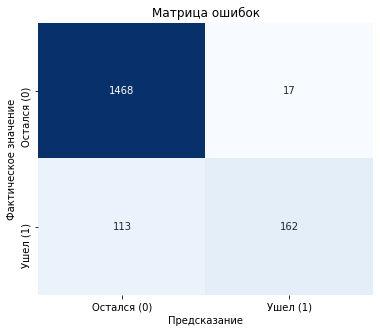

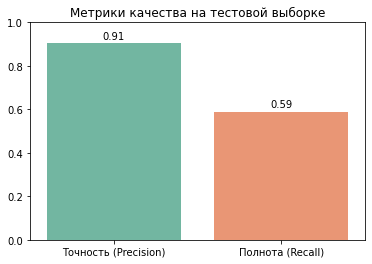

Точность (Precision): 0.905
Полнота (Recall): 0.589


In [196]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Остался (0)', 'Ушел (1)'],
            yticklabels=['Остался (0)', 'Ушел (1)'])
plt.xlabel('Предсказание')
plt.ylabel('Фактическое значение')
plt.title('Матрица ошибок')
plt.show()

precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)

plt.figure(figsize=(6,4))
sns.barplot(x=['Точность (Precision)', 'Полнота (Recall)'], 
            y=[precision, recall], palette='Set2')
plt.ylim(0,1)
plt.title('Метрики качества на тестовой выборке')
for i, v in enumerate([precision, recall]):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center')
plt.show()

print(f'Точность (Precision): {precision:.3f}')
print(f'Полнота (Recall): {recall:.3f}')

Модель демонстрирует Precision = 0.905 и Recall = 0.589, т.е. модель корректно "улавливает" 58,9% ушедших клиентов (162 из 275). Из матрицы ошибок видно, что система лучше выявляет оставшихся клиентов (1468 из 1485, Precision ≈91%), чем ушедших. 

**Итого:** Модель очень точна при классифицировании не склонных к уходу клиентов, при этом она находит не всех уходящих — примерно 6 из 10. То есть для точечных удерживающих акций модель уже отлично подходит: можно контактировать через узкий список выделенных клиентов и почти не тратить ресурсы зря. Если же задача — поймать больше потенциальных уходов, можно чуть снизить порог срабатывания модели: охват вырастет, мы заметим больше рисковых клиентов, но точность прогнозов немного снизится.

Оценим важность признаков для лучшей модели. Это поможет интерпретировать результаты модели и подготовить рекомендации для заказчика. Построим график важности признаков с помощью метода SHAP. Предварительно нужно повторить обработку датасета для подачи методу через тот же пайплайн.

In [180]:
best_preprocessor = grid_search.best_estimator_.named_steps['preprocessor']

In [181]:
X_train_transformed = pd.DataFrame(
    best_preprocessor.transform(X_train),  
    columns=best_preprocessor.get_feature_names_out()
)

X_test_transformed = pd.DataFrame(
    best_preprocessor.transform(X_test),
    columns=best_preprocessor.get_feature_names_out()
)

In [182]:
display(X_train_transformed.head(2))
display(X_test_transformed.head(2))

,ohe__type_One year,ohe__type_Two year,ohe__paperless_billing_Yes,ohe__payment_method_Credit card (automatic),ohe__payment_method_Electronic check,ohe__payment_method_Mailed check,ohe__gender_Male,ohe__senior_citizen_1,ohe__partner_Yes,ohe__dependents_Yes,ohe__multiple_lines_No,ohe__multiple_lines_Yes,num__monthly_charges,num__total_charges,num__contract_duration,num__internet_services_count
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,58.50,245.70,123.0,2.0
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,100.75,4735.25,1432.0,4.0


,ohe__type_One year,ohe__type_Two year,ohe__paperless_billing_Yes,ohe__payment_method_Credit card (automatic),ohe__payment_method_Electronic check,ohe__payment_method_Mailed check,ohe__gender_Male,ohe__senior_citizen_1,ohe__partner_Yes,ohe__dependents_Yes,ohe__multiple_lines_No,ohe__multiple_lines_Yes,num__monthly_charges,num__total_charges,num__contract_duration,num__internet_services_count
0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,70.15,4419.45,1826.0,4.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,23.95,1652.55,2102.0,0.0


In [185]:
explainer = shap.TreeExplainer(grid_search.best_estimator_[-1])
shap_values = explainer(X_test_transformed)

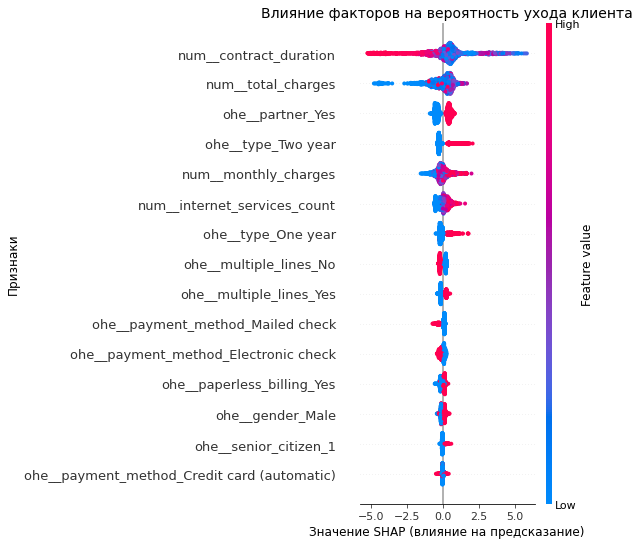

In [188]:
shap.summary_plot(shap_values, X_test_transformed, plot_type='dot', max_display=15, show=False)

plt.title('Влияние факторов на вероятность ухода клиента', fontsize=14)
plt.ylabel('Признаки', fontsize=12)
plt.xlabel('Значение SHAP (влияние на предсказание)', fontsize=12)
plt.show()

1. **Стаж договора (`contract_duration`)** - ключевой фактор. Большие значения (красные точки) тянут предсказание влево, то есть долгий стаж снижает риск. Короткий стаж (синие точки) чаще связан с уходом.

2. **Накопленные платежи (`total_charges`)** - также важный признак. Высокие суммы уменьшают вероятность ухода, низкие — повышают. Это согласуется со стажем: чем дольше клиент в компании, тем выше сумма накопленных платежей.

3. **Тип контракта (`type`)** - фиксированные договоры «удерживают»: `Two year` сильнее всего снижает риск, `One year` — тоже в минус к оттоку, но слабее. 

4. **Ежемесячный платёж (`monthly_charges`)** - Чем выше платёж, тем больше красных точек справа: высокая цена повышает вероятность ухода (ценовая чувствительность).

5. **Количество интернет-услуг (`internet_services_count`)** Рост числа подключённых сервисов смещает точки вправо: много допуслуг — больший риск, вероятно из-за общей стоимости и ожиданий по качеству.
   
4. **Дополнительные факторы**. Использование телефонных линий, пол, метод оплаты, статус (пенсионер/нет) оказывают меньшее влияние на итоговое предсказание, однако в комбинации с другими факторами могут повышать риск.

В целом результаты анализа важности признаков подтверждают наши выводы полученные при исследовательском анализе данных: ыше всего риски у клиентов на «дорогих» пакетах с несколькими сервисами и коротким стажем/месячным договором; самые «спокойные» — с долгим стажем, фиксированным контрактом и предсказуемым способом оплаты.

По анализу SHAP наибольший вклад в вероятность оттока даёт признак `contract_duration` (стаж договора). Чтобы убедиться в характере зависимости, построим график зависимости этого и целевого признаков: посчитаем долю ушедших для каждого интервала продолжительности догоовра (~ 6 мес/180 дней) и визуализируем её столбчатой диаграммой.

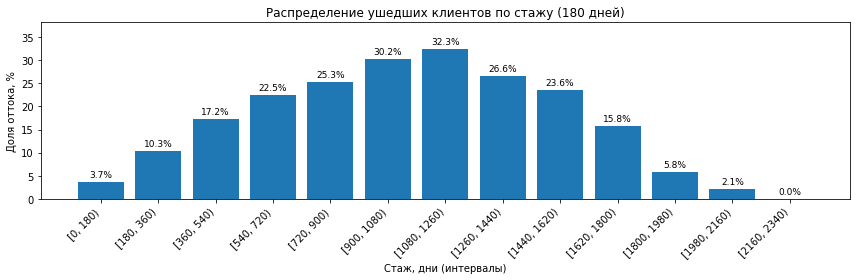

In [206]:
step = 180
bins = np.arange(0, df_full['contract_duration'].max() + step, step)

tmp = (df_full
       .assign(bin=pd.cut(df_full['contract_duration'], bins=bins, right=False))
       .groupby('bin', observed=True)['target']
       .agg(churn_rate='mean', n='count')
       .reset_index())

plt.figure(figsize=(12, 4))

y = tmp['churn_rate'] * 100
x = tmp['bin'].astype(str)

bars = plt.bar(x, y)

for i, val in enumerate(y):
    plt.text(i, val + max(y)*0.02, f'{val:.1f}%', ha='center', va='bottom', fontsize=9)

plt.ylim(0, max(y) * 1.18)

plt.xticks(rotation=45, ha='right')
plt.ylabel('Доля оттока, %')
plt.xlabel('Стаж, дни (интервалы)')
plt.title(f'Распределение ушедших клиентов по стажу ({step} дней)')
plt.tight_layout()
plt.show()

По графику наблюдается четкая нелинейная зависимость между длительностью контракта и долей ушедших клиентов: риск оттока возрастает в первые 3,5 года, достигая пика (30-32%) на 2,5-3,5 годах, что соответствует периоду перезаключении договоров. После этого порога формируется "ядро лояльных" клиентов - с ростом стажа отток стабильно снижается до 6% к 5 годам и менее.

<b>Вывод по разделу "Тестирование модели"</b>

**Матрица ошибок и метрики качества:** \
CatBoost-модель демонстрирует высокое качество (ROC-AUC = 0.924) и устойчивость на тестовой выборке. При точности 92.6% модель характеризуется высокой метрикой precision (90.5%) при умеренной полноте (58.9%), что свидетельствует о минимальном количестве ложных срабатываний при выявлении 59% реальных уходов.

**Анализ важности факторов (SHAP):**
Ключевыми драйверами оттока являются:
- Длительность контракта и накопленные платежи (обратная зависимость)
- Тип контракта (фиксированные договоры снижают риск оттока)
- Ежемесячные платежи (прямая зависимость)
- Количество интернет-сервисов (прямая зависимость)
Персональные и вспомогательные признаки оказывают второстепенное влияние.

**Дополнительное исследование признака "Длительность контракта":**
Выявлена нелинейная зависимость с целевым признаком: риск оттока прогрессивно возрастает до пиковых значений (30-32%) на 2.5-3.5 годах, после чего существенно снижается для лояльных клиентов (до 6% к 5 годам). 

## Выводы

В ходе работы была разработана модель прогнозирования оттока клиентов на основе **CatBoost с ROC-AUC 0.924**. Модель демонстрирует хорошее соотношение точности (90.5%) и полноты (58.9%), позволяя идентифицировать клиентов группы риска с достаточной точностью. 

Параметры лучшей модели: CatBoostClassifier - `depth`: 4, `iterations`: 1000, `l2_leaf_reg`: 3, `learning_rate`: 0.1.

С помощью метода SHAP были определены ключевые факторы оттока:
- Короткий стаж договора и низкие накопленные платежи
- Помесячный тип контракта (фиксированные договоры снижают риск)
- Высокие ежемесячные платежи и избыточное количество сервисов
- Пик оттока на 2.5-3.5 годах с последующим снижением риска

В текущем виде модель готова к внедрению для точечных удерживающих кампаний с фокусом на клиентах в "окнах риска". Также можно чуть снизить порог срабатывания модели для увеличения охвата клиентов и рассылки персонализированных предложений. 

**Рекомендации по удержанию клиентов** \
Основной драйвер оттока — длительность договора. Для снижения рисков рекомендуется:
- Разработать программы лояльности для новых клиентов в период адаптации (первые несколько месяцев)
- Внедрить специальные условия для долгосрочных клиентов ("старичков"). Высылать спец-предложения по пролонгированию долгосрочных договоров (скидка при "переподписании", доп.бесплатный период (+месяц в подарок).
- Демографические характеристики (возраст, наличие детей) имеют минимальное влияние на отток, поэтому не должны быть приоритетом в удерживающих кампаниях.
- Финансовые факторы (суммарные и ежемесячные расходы) значимы — целесообразно оптимизировать тарифную политику: предложить гибкие пакеты услуг для контроля расходов клиентов.

Для повышения точности прогноза оттока можно:
- дополнить данные информацией о сбоях, жалобах, авариях и падениях скорости, чтобы выявить возможные дополнительные причины ухода клиентов с долгосрочными договорами
- увеличить выборку по возможности для улучшения обучения нейросети
- удалить "шумные" признаки не оказывающие значительного влияния на отток (пол, дети и тп).